In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import gc
import glob
import torch
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy
import utils
import math
import skimage.measure

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
model_type = 'twins'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['CEU-2', 'GRL-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-0', 'JPN-1']

In [3]:
omni = utils.loading_solarwind()
omni.describe()

Loading solar wind data....


,B_Total,BY_GSM,BZ_GSM,Vx,Vy,Vz,proton_density,T,Pressure,E_Field
count,1.253767e+07,1.253767e+07,1.253767e+07,1.173913e+07,1.164550e+07,1.164550e+07,1.170630e+07,1.173142e+07,1.170629e+07,1.173360e+07
mean,-2.544673e-02,1.667299e-02,-1.375428e-02,4.298754e+02,5.442742e-01,-3.981075e+00,6.194855e+00,8.797294e+04,2.118271e+00,8.818358e-03
std,4.160188e+00,4.065572e+00,3.444922e+00,1.023021e+02,2.686590e+01,2.425166e+01,5.170458e+00,8.503556e+04,1.922729e+00,1.679041e+00
min,-6.240295e+01,-5.624695e+01,-7.833755e+01,0.000000e+00,-2.240300e+02,-2.575700e+02,0.000000e+00,0.000000e+00,0.000000e+00,-7.398622e+01
25%,-2.701167e+00,-2.567354e+00,-1.810860e+00,3.558500e+02,-1.630000e+01,-1.901000e+01,3.115000e+00,3.417700e+04,1.154897e+00,-7.457514e-01
50%,1.825000e-02,-2.388826e-02,-2.821622e-03,4.078500e+02,-1.250000e+00,-4.260000e+00,4.809000e+00,6.432300e+04,1.679634e+00,-4.140328e-04
75%,2.674125e+00,2.585714e+00,1.797299e+00,4.830500e+02,1.514000e+01,1.101000e+01,7.519200e+00,1.162100e+05,2.510810e+00,7.530893e-01
max,5.173780e+01,5.691044e+01,6.687061e+01,1.999500e+03,3.108400e+02,4.460000e+02,2.071900e+02,1.059700e+07,6.563812e+02,8.622638e+01


In [4]:
scalers = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		scalers[key] = {}
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_alt_v4_oversampling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_alt_v4_oversampling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
			# if os.path.exists(f'{scaler_dir}/swmag_{key}_swmag_v6-oversampling.pkl'):
			# 	with open(f'{scaler_dir}/swmag_{key}_swmag_v6-oversampling.pkl', 'rb') as f:
			# 		scaler_values = pickle.load(f)
			# 		scalers[key]['swmag'] = scaler_values
			# 		print(f'{key} scalers loaded')
		else:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_alt_v4.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_alt_v4.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
			# if os.path.exists(f'{scaler_dir}/swmag_{key}_swmag_v6-1.pkl'):
			# 	with open(f'{scaler_dir}/swmag_{key}_swmag_v6-1.pkl', 'rb') as f:
			# 		scaler_values = pickle.load(f)
			# 		scalers[key]['swmag'] = scaler_values
			# 		print(f'{key} scalers loaded')

In [8]:

def loading_shap_dicts(region, reg, model_type, add_results=False):
	
	shap_dir = 'outputs/shap_values'
	results_dir = f'outputs/{model_type}'
	if model_type == 'dbht':
		results_dir = results_dir + '_max'
	root = f'twins_region_{reg}_twins_'
	stem = 'alt_v4_dbht' if model_type == 'dbht' else 'alt_v4'
	if reg in list_of_oversampled_regions:
		stem = stem + '_oversampling' 
	tree_path = os.path.join(shap_dir, root + stem +'.pkl')
	
	if add_results:
		results_stem = f'twins_modeling_region_{reg}_version_twins_' + stem
		results_path = os.path.join(results_dir, results_stem + '.feather')

		df = pd.read_feather(results_path)
		df.set_index('dates', inplace=True)

		region[f'{model_type}_results'] = df

	with open(tree_path, 'rb') as f:
		shap_values = pickle.load(f)
		region[model_type] = shap_values

		print(f'finished {reg} {model_type}')
	

def inverse_transform_twins(X, mean, std):
	return X*std + mean

def transforming_shap_values(region, reg, model_type, scalers, twins_or_swmag='twins', mean_or_std='mean'):

	loading_shap_dicts(region, reg, model_type, add_results=True)

	input_array_int = 0 if twins_or_swmag == 'swmag' else 1
	mean_or_std_int = 0 if mean_or_std == 'mean' else 1

	swmag_str = f'swmag_{mean_or_std}_shap'
	twins_str = f'twins_{mean_or_std}_shap'

	region[model_type][swmag_str] = np.concatenate([region[model_type]['shap_values'][i][mean_or_std_int][0][:,:,:,:] for i in range(len(region[model_type]['shap_values']))], axis=0)
	region[model_type][twins_str] = np.concatenate([region[model_type]['shap_values'][i][mean_or_std_int][1][:,:,:,:] for i in range(len(region[model_type]['shap_values']))], axis=0)

	for key in region[model_type].keys():
		if isinstance(region[model_type][key], torch.Tensor):
			region[model_type][key] = region[model_type][key].numpy()

	swmag_shape, twins_shape = region[model_type][swmag_str].shape, region[model_type][twins_str].shape

	region[model_type][swmag_str] = region[model_type][swmag_str].reshape(swmag_shape[0], swmag_shape[2], swmag_shape[3])
	region[model_type][twins_str] = region[model_type][twins_str].reshape(twins_shape[0], twins_shape[2], twins_shape[3])

	# if len(region[model_type]['testing_data'][1].shape) > 3:
		# testing_shape = region[model_type]['testing_data'][input_array_int].shape
		# region[model_type]['testing_data'][input_array_int] = region[model_type]['testing_data'][input_array_int].reshape(testing_shape[0], testing_shape[2], testing_shape[3])
	
	# # unscaling the testing_data
	# if twins_or_swmag == 'twins':
	# 	mu = scalers[reg][model_type]['twins_mean']
	# 	sigma = scalers[reg][model_type]['twins_std']
	# 	region[model_type]['testing_data'][1] = region[model_type]['testing_data'][1]*sigma + mu
	# else:
	# 	scaler = scalers[reg][model_type]['swmag_scaler']
	# 	region[model_type]['testing_data'][0] = scaler.inverse_transform(region[model_type]['testing_data'][0].reshape(-1,1)).reshape(-1, region[model_type]['testing_data'][0].shape[1], region[model_type]['testing_data'][0].shape[2])
	
	value_added = np.sum(np.sum(np.abs(region[model_type][swmag_str]), axis=1),axis=1) + np.sum(np.sum(np.abs(region[model_type][twins_str]), axis=1),axis=1)
	# region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap'] = region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap']/value_added[:,None,None]
	region[model_type][twins_str] = region[model_type][twins_str]/value_added[:,None,None]
	region[model_type][swmag_str] = region[model_type][swmag_str]/value_added[:,None,None]

	region[model_type].pop('shap_values', None) 
	inputs, stat = ['swmag','twins'], ['mean','std']
	# for inp in inputs:
	# 	for st in stat:
	# 		if f'{inp}_{st}_shap' != f'{twins_or_swmag}_{mean_or_std}_shap':
	# 			region[model_type].pop(f'{inp}_{st}_shap', None)
	gc.collect()

with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)
	
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
			transforming_shap_values(region, reg, 'dbht', scalers)

			gc.collect()	
			transforming_shap_values(region, reg, 'rsd', scalers)
			gc.collect()
# for cluster in cluster_dict.values():
# 	for region in cluster['regions'].values():
# 		region['mean_lat'] = utils.getting_mean_lat(region['stations'])
# 		gc.collect()

finished CAN-0 dbht
finished CAN-0 rsd
finished CAN-1 dbht
finished CAN-1 rsd
finished CAN-2 dbht
finished CAN-2 rsd
finished GRL-0 dbht
finished GRL-0 rsd
finished GRL-1 dbht
finished GRL-1 rsd
finished GRL-2 dbht
finished GRL-2 rsd
finished GRL-3 dbht
finished GRL-3 rsd
finished FSC-0 dbht
finished FSC-0 rsd
finished FSC-1 dbht
finished FSC-1 rsd
finished FSC-2 dbht
finished FSC-2 rsd
finished FSC-3 dbht
finished FSC-3 rsd
finished FSC-4 dbht
finished FSC-4 rsd
finished FSC-5 dbht
finished FSC-5 rsd
finished FSC-6 dbht
finished FSC-6 rsd
finished CEU-0 dbht
finished CEU-0 rsd
finished CEU-1 dbht
finished CEU-1 rsd
finished CEU-2 dbht
finished CEU-2 rsd
finished CEU-3 dbht
finished CEU-3 rsd
finished SVLB dbht
finished SVLB rsd
finished JPN-0 dbht
finished JPN-0 rsd
finished JPN-1 dbht
finished JPN-1 rsd
finished ALSK dbht
finished ALSK rsd
finished HUD-0 dbht
finished HUD-0 rsd
finished HUD-1 dbht
finished HUD-1 rsd


In [9]:
print(cluster_dict['greenland_cluster']['regions']['GRL-0']['rsd'].keys())
print(cluster_dict['greenland_cluster']['regions']['GRL-0']['rsd']['swmag_mean_shap'].shape)



dict_keys(['testing_data', 'ytest', 'Date_UTC', 'features', 'expected_values', 'swmag_mean_shap', 'twins_mean_shap'])
(12066, 30, 14)


In [10]:
def getting_mean_influence(twins_array, swmag_array, stations, features):
	mlat = utils.getting_mean_lat(stations)
	twins_array = np.mean(np.sum(np.sum(np.abs(twins_array), axis=1), axis=1),axis=0)
	swmag_array = np.mean(np.sum(np.abs(swmag_array), axis=1), axis=0)
	full_array = np.hstack([swmag_array, twins_array])
	full_array = full_array/np.sum(full_array)
	features = [feat for feat in features] + ['ion_temp']
	data = pd.DataFrame({feat: full_array[i] for i, feat in enumerate(features)}, index=[mlat])
	return data, features


In [11]:

rsd_mean_importance, dbht_mean_importance = pd.DataFrame(), pd.DataFrame()
for cluster in cluster_dict.values():
	for region in cluster['regions'].keys():
		temp_rsd, rsd_features = getting_mean_influence(cluster['regions'][region]['rsd']['twins_mean_shap'], 
											cluster['regions'][region]['rsd']['swmag_mean_shap'], 
											cluster['regions'][region]['stations'], 
											cluster['regions'][region]['rsd']['features'])
		temp_dbht, dbht_features = getting_mean_influence(cluster['regions'][region]['dbht']['twins_mean_shap'], 
											cluster['regions'][region]['dbht']['swmag_mean_shap'], 
											cluster['regions'][region]['stations'], 
											cluster['regions'][region]['dbht']['features'])
												
		rsd_mean_importance = pd.concat([rsd_mean_importance, temp_rsd])
		dbht_mean_importance = pd.concat([dbht_mean_importance, temp_dbht])

Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station 

In [12]:
print(rsd_mean_importance.sum(axis=1))

56.048641    1.0
58.461914    1.0
60.342609    1.0
72.206985    1.0
73.520126    1.0
74.757584    1.0
67.902069    1.0
62.933891    1.0
59.167683    1.0
66.231537    1.0
66.092812    1.0
65.293945    1.0
63.911121    1.0
65.417793    1.0
45.697987    1.0
49.579941    1.0
42.963829    1.0
51.407284    1.0
74.913689    1.0
25.155876    1.0
37.010193    1.0
65.403923    1.0
61.946777    1.0
71.613419    1.0
dtype: float64


['dbht_median', 'MAGNITUDE_median', 'MAGNITUDE_std', 'sin_theta_std', 'cos_theta_std', 'cosMLT', 'sinMLT', 'B_Total', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'proton_density', 'logT', 'ion_temp']
(24, 15)
(24, 15)
15
16
['dbht_median', 'MAGNITUDE_median', 'MAGNITUDE_std', 'sin_theta_std', 'cos_theta_std', 'cosMLT', 'sinMLT', 'B_Total', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'proton_density', 'logT', 'ion_temp']
(24, 15)
(24, 15)
15
16


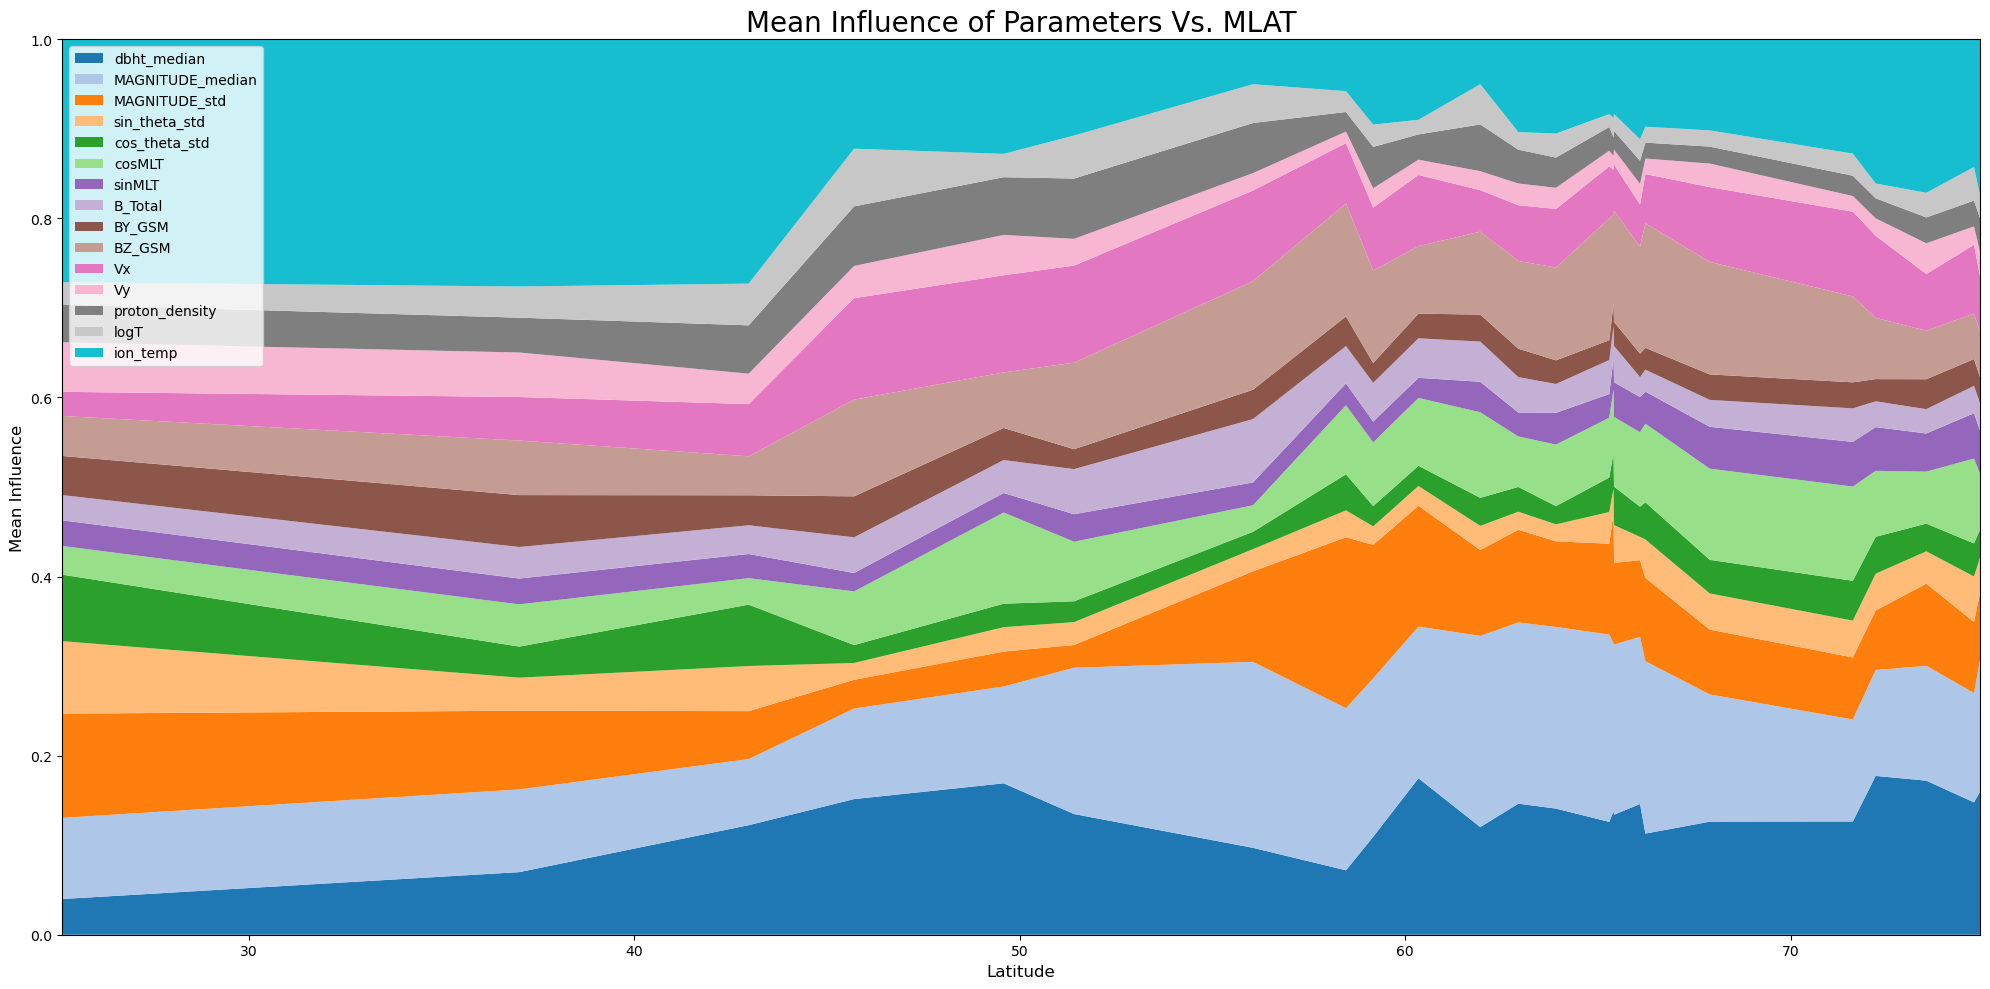

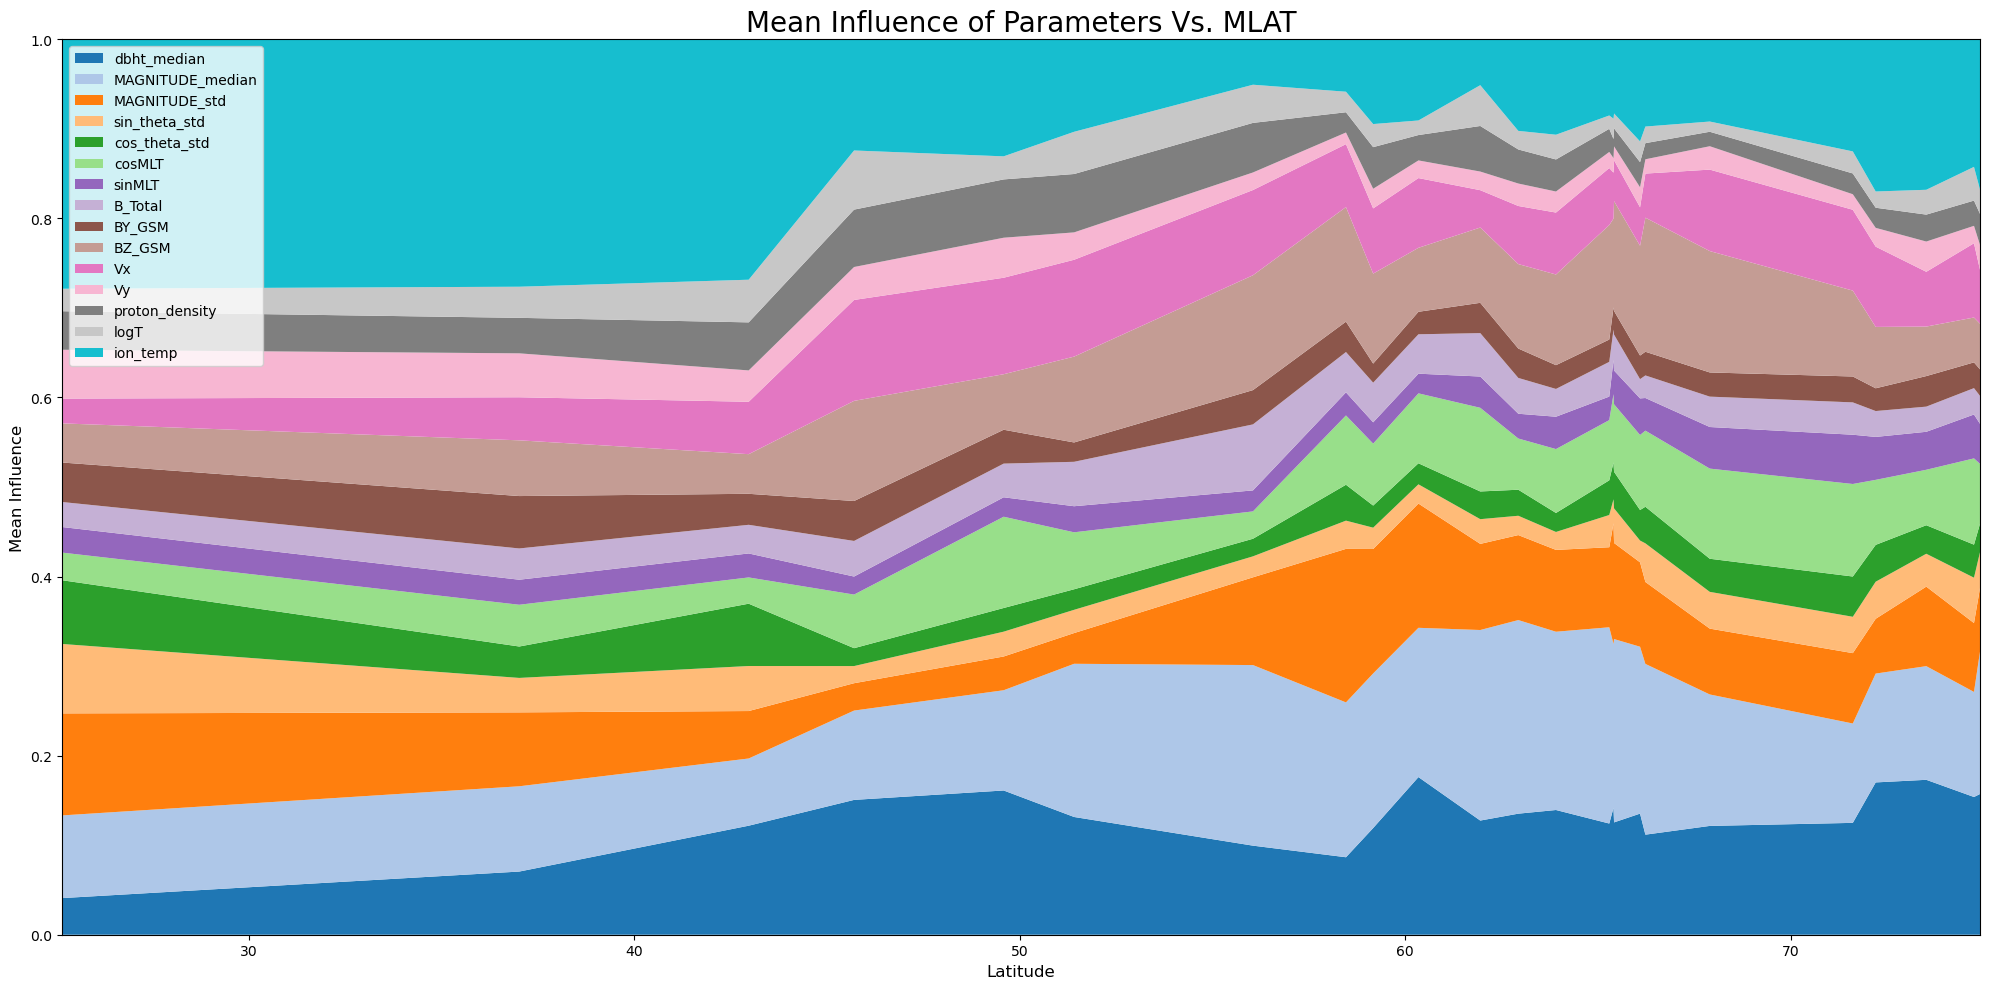

In [15]:

# # Summing up the total influence of each parameter and plotting them as a function of latitude
# influence_df = pd.DataFrame(columns=[feature for feature in features], index=[twins_shap[region]['mlat'] for region in twins_shap.keys()])

# for feature in features:
# 	feature_list = []
# 	for region in twins_shap.keys():
# 		feature_list.append(np.mean(np.sum(np.abs(twins_shap[region]['sw_mean']),axis=1)[:, features.index(feature)]))

# 	influence_df[feature] = feature_list

# influence_df['twins_maps'] = [np.mean(np.sum(np.sum(np.abs(twins_shap[region]['twins_mean']),axis=1),axis=1)) for region in twins_shap.keys()]

# adjusted_features = features.copy()
# adjusted_features.append('twins_maps')

colors = sns.color_palette('tab20', len(rsd_features)+7)
colors.pop(-1)
colors.pop(-4)
colors.pop(-4)
colors.pop(6)
colors.pop(6)
colors.pop(-2)

print(rsd_features)
rsd_mean_importance = rsd_mean_importance.sort_index()
print(rsd_mean_importance.shape)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
axes.set_title('Mean Influence of Parameters Vs. MLAT', fontsize=20)
axes.set_ylabel('Mean Influence', fontsize=12)
axes.set_xlabel('Latitude', fontsize=12)
# plotting_list = [rsd_mean_importance[feature].values for feature in features]
plotting_list = rsd_mean_importance.to_numpy()
print(plotting_list.shape)
print(len(rsd_features))
print(len(colors))
axes.stackplot(rsd_mean_importance.index, plotting_list.T, labels=rsd_features, colors=colors)
axes.margins(x=0, y=0)
axes.legend(loc='upper left')
plt.tight_layout()
plt.savefig('plots/rsd_mean_influence.png')

colors = sns.color_palette('tab20', len(dbht_features)+7)
colors.pop(-1)
colors.pop(-4)
colors.pop(-4)
colors.pop(6)
colors.pop(6)
colors.pop(-2)

print(dbht_features)
dbht_mean_importance = dbht_mean_importance.sort_index()
print(dbht_mean_importance.shape)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
axes.set_title('Mean Influence of Parameters Vs. MLAT', fontsize=20)
axes.set_ylabel('Mean Influence', fontsize=12)
axes.set_xlabel('Latitude', fontsize=12)
# plotting_list = [rsd_mean_importance[feature].values for feature in features]
plotting_list = dbht_mean_importance.to_numpy()
print(plotting_list.shape)
print(len(dbht_features))
print(len(colors))
axes.stackplot(dbht_mean_importance.index, plotting_list.T, labels=dbht_features, colors=colors)
axes.margins(x=0, y=0)
axes.legend(loc='upper left')
plt.tight_layout()
plt.savefig('plots/dbht_mean_influence.png')


In [23]:
class Twins_SHAP():

	def __init__(self, shap_dir, scaler_dir, cluster_dict):
		self.shap_dir = shap_dir
		self.scaler_dir = scaler_dir
		self.cluster_dict = cluster_dict
		self.model_type = 'twins'
		self.oversampled = ['CEU-2', 'GRL-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-0', 'JPN-1']

	def load_shap_values_and_ion_temp_data(self, cluster, region):

		if region in self.oversampled:
			if os.path.exists(f'{self.shap_dir}/twins_{region}_twins_alt_method_v2_maxpooling_oversampling.pkl'):
				with open(f'{self.shap_dir}/twins_{region}_twins_alt_method_v2_maxpooling_oversampling.pkl', 'rb') as f:
					self.shap_values = pickle.load(f)
			if os.path.exists(f'{self.scaler_dir}/twins_{region}_twins_alt_method_v2_maxpooling_oversampling.pkl'):
				with open(f'{self.scaler_dir}/twins_{region}_twins_alt_method_v2_maxpooling_oversampling.pkl', 'rb') as f:
					self.scaler_values = pickle.load(f)
		else:
			if os.path.exists(f'{self.shap_dir}/twins_{region}_twins_alt_method_v2_maxpooling.pkl'):
				with open(f'{self.shap_dir}/twins_{region}_twins_alt_method_v2_maxpooling.pkl', 'rb') as f:
					self.shap_values = pickle.load(f)
			if os.path.exists(f'{self.scaler_dir}/twins_{region}_twins_alt_method_v2_maxpooling.pkl'):
				with open(f'{self.scaler_dir}/twins_{region}_twins_alt_method_v2_maxpooling.pkl', 'rb') as f:
					self.scaler_values = pickle.load(f)

		# loading ion temperature data
		self.testing_data = shap_values['testing_data'][1]
		self.testing_data = np.reshape(self.testing_data, (self.testing_data.shape[0], self.testing_data.shape[2], self.testing_data.shape[3]))

		# unscaling ion temps
		self.testing_data = self.testing_data*scaler_values['twins_std'] + scaler_values['twins_mean']

		# putting the shap values together and removing channel dimension
		self.shap_data = np.concatenate([shap_values['shap_values'][i][0][1][:,:,:,:] for i in range(len(shap_values['shap_values']))], axis=0)
		self.shap_data = np.reshape(self.shap_data, (self.shap_data.shape[0], self.shap_data.shape[2],self.shap_data.shape[3]))

		# loading the location data for this region
		mlt_station = utils.loading_supermag(self.cluster_dict[cluster]['regions'][region]['mlt_station'])
		self.location_df = mlt_station[['MLT','MLAT']][mlt_station.index.isin(shap_values['Date_UTC']['Date_UTC'])]

		# binning MLT  for plotting and transforming 24 --> 0 for consistency
		self.location_df['MLT'] = self.location_df['MLT'].round(0)
		self.location_df.loc[self.location_df['MLT'] == 24, 'MLT'] = 0
		
	def mlt_wedge(self, img_data, mlt_min: int = 18, mlt_max: int = 6, center_x: int = 120, center_y: int = 80):
		"""
		This function takes in a temperature ENA image and divides thems into pie slices based on the
		numbers of slices desired. The output of the function is an array of the mean different sections of the
		ENA temperature map generated and the different sections themselves, respectively.
		Parameters:
		-----------
		img_data : ndarray
			Input image data.
		mlt_min : int, optional
			Minimum MLT value. Default is 18.
		mlt_max : int, optional
			Maximum MLT value. Default is 6.
		mlt_span : int, optional
			MLT span. Default is 1.
		angle_steps : int, optional
			Number of angle steps for pie slices. Default is 8.
		center_x : int, optional
			X-coordinate of the center. Default is 120.
		center_y : int, optional
			Y-coordinate of the center. Default is 80.
		Returns:
		--------
		selected_sections : list
			List of selected pie slice sections.
		"""
		# get the dimension of the image
		height, width = img_data.shape
		# Create an empty list to store the selected sections
		selected_sections = []
		img_mean = []
		# define the numbers of angles used for the pie slices
		# Create masks for each N-degree section and apply them to the image
		# Create a new blank mask as a NumPy array
		mask = np.zeros((height, width), dtype=np.uint8)
		img_copy = np.copy(img_data)
		# Calculate the coordinates of the sector's bounding box

		start_angle = (mlt_min*15) % 360
		end_angle = (mlt_max*15) % 360

		# Calculate the coordinates of the sector arc
		for y in range(height):
			for x in range(width):
				# Calculate the polar coordinates of the pixel relative to the image center
				dx = center_x - x
				dy = center_y - y
				pixel_angle = math.degrees(math.atan2(dy, dx))  # Calculate the angle in radians
				if pixel_angle < 0:
					pixel_angle += 360
				# Check if the pixel is within the current 45-degree section
				if mlt_min > mlt_max:
					if start_angle <= pixel_angle < 360 or 0 <= pixel_angle < end_angle:
						mask[y, x] = 1
				else:
					if start_angle <= pixel_angle < end_angle:
						mask[y, x] = 1  # Set the pixel to white (255)
		# Apply the mask to the heat map to select the section
		img_copy[mask == 0] = 0
		# Append the selected section to the list
		selected_sections = img_copy
		xx = np.copy(img_copy)
		xx[xx == 0] = np.nan

		# Get the mean of the non zero values of the image
		if np.isnan(xx).all():
			img_mean.append(np.nan)
		else:
			img_mean.append(np.nanmean(xx))

		return img_mean, selected_sections

	def getting_valid_map_values(self, shap_img, testing_img, mlt, mlat):

		mlt_min = mlt-2 if mlt >=2 else 24+mlt-2
		mlt_max = mlt+2 if mlt <=22 else mlt-24+2

		# getting the valid values of the shap image
		shap_mean, shap_img = self.mlt_wedge(img_data=shap_img, mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
		testing_mean, testing_img = self.mlt_wedge(img_data=testing_img, mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)

		valid_pixel_df = pd.DataFrame({'shap': shap_img.flatten(), 'testing': testing_img.flatten()})
		valid_pixel_df = valid_pixel_df.dropna()
		valid_pixel_df = valid_pixel_df[(valid_pixel_df['shap'] != 0) & (valid_pixel_df['testing'] != 0)]
		valid_pixel_df['MLT'] = mlt
		valid_pixel_df['MLAT'] = mlat

		valid_mean_df = pd.DataFrame({'shap': shap_mean, 'testing': testing_mean, 'MLT': mlt, 'MLAT': mlat})
		valid_mean_df = valid_mean_df.dropna()

		return valid_pixel_df, valid_mean_df

	def pool(self, shap_img, testing_img, pooling_size=(2,2), pooling_type='mean'):

		if not isinstance(shap_img, np.ndarray):
			shap_img = np.array(shap_img)
		if not isinstance(testing_img, np.ndarray):
			testing_img = np.array(testing_img)

		if pooling_type == 'mean':
			shap_img = skimage.measure.block_reduce(shap_img, block_size=pooling_size, func=np.mean)
			testing_img = skimage.measure.block_reduce(testing_img, block_size=pooling_size, func=np.mean)
		elif pooling_type == 'max':
			shap_img = skimage.measure.block_reduce(shap_img, block_size=pooling_size, func=np.max)
			testing_img = skimage.measure.block_reduce(testing_img, block_size=pooling_size, func=np.max)

		return shap_img, testing_img

	def returning_dataframe(self, shap_img, testing_img, mlt, mlat):

		shap_img = shap_img.flatten()
		testing_img = testing_img.flatten()

		valid_pixel_df = pd.DataFrame({'shap': shap_img, 'testing': testing_img})
		valid_pixel_df = valid_pixel_df.dropna()
		valid_pixel_df['MLT'] = mlt
		valid_pixel_df['MLAT'] = mlat

		return valid_pixel_df


	def __call__(self, pooling=False, wedge=False):

		if pooling:
			ion_temp_df = pd.DataFrame()
		elif wedge:
			ion_temp_df, mean_ions_df = pd.DataFrame(), pd.DataFrame()
		elif pooling and wedge:
			raise ValueError('Only one of pooling or wedge can be set to True')
		else:
			raise ValueError('One of pooling or wedge must be set to True')

		for cluster in self.cluster_dict.keys():
			for region in self.cluster_dict[cluster]['regions'].keys():
				# loading shap values and ion temperature data
				self.load_shap_values_and_ion_temp_data(cluster, region)
				# getting the valid values of the shap image
				for shap, test, mlt, mlat in zip(self.shap_data, self.testing_data, self.location_df['MLT'], self.location_df['MLAT']):
					if pooling:
						shap, test = self.pool(shap, test, pooling_size=(3,5), pooling_type='mean')
						valid_pixel_df = self.returning_dataframe(shap, test, mlt, mlat)
						if not valid_pixel_df.empty:
							ion_temp_df = pd.concat([ion_temp_df, valid_pixel_df], axis=0)
					elif wedge:
						valid_pixel_df, valid_mean_df = self.getting_valid_map_values(shap, test, mlt, mlat)
						if not valid_pixel_df.empty:
							ion_temp_df = pd.concat([ion_temp_df, valid_pixel_df], axis=0)
						if not valid_mean_df.empty:
							mean_ions_df = pd.concat([mean_ions_df, valid_mean_df], axis=0)

		if pooling:
			return ion_temp_df
		elif wedge:
			return ion_temp_df, mean_ions_df


twins_shap = Twins_SHAP(shap_dir, scaler_dir, cluster_dict)
ion_temp_df = twins_shap(pooling=True)

Loading station NEW....
Loading station LET....
Loading station MEA....
Loading station STF....
Loading station GDH....
Loading station GDH....
Loading station NAQ....
Loading station LYC....
Loading station NUR....
Loading station ABK....
Loading station ABK....
Loading station ABK....


In [16]:
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		if key in list_of_oversampled_regions:
			# if os.path.exists(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-oversampling.pkl'):
			# 	with open(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-oversampling.pkl', 'rb') as f:
			# 		shap_values = pickle.load(f)
			# 		cluster['regions'][key]['swmag_shap'] = shap_values
			if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_alt_v4_oversampling.pkl'):
				with open(f'{shap_dir}/twins_region_{key}_twins_alt_v4_oversampling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					feature_list = shap_values['features']
					cluster['regions'][key]['twins_shap'] = {}
					cluster['regions'][key]['twins_shap']['testing_data'] = shap_values['testing_data'][0]
					cluster['regions'][key]['twins_shap']['mean_shap'] = np.concatenate([shap_values['shap_values'][i][0][0][:,:,:,:] for i in range(len(shap_values['shap_values']))], axis=0)
					mlt_station = utils.loading_supermag(cluster['regions'][key]['mlt_station'])
					location_df = mlt_station[['MLT','MLAT']][mlt_station.index.isin(shap_values['Date_UTC']['Date_UTC'])]
					cluster['regions'][key]['location'] = location_df

					# cluster['regions'][key]['twins_shap']['std_shap'] = np.concatenate([shap_values['shap_values'][i][1][1][:,:,:,:] for i in range(len(shap_values['shap_values']))], axis=0)
		else:
			# if os.path.exists(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-1.pkl'):
			# 	with open(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-1.pkl', 'rb') as f:
			# 		shap_values = pickle.load(f)
			# 		cluster['regions'][key]['swmag_shap'] = shap_values
			if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_alt_v4.pkl'):
				with open(f'{shap_dir}/twins_region_{key}_twins_alt_v4.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['twins_shap'] = {}
					cluster['regions'][key]['twins_shap']['testing_data'] = shap_values['testing_data'][0]
					cluster['regions'][key]['twins_shap']['mean_shap'] = np.concatenate([shap_values['shap_values'][i][0][0][:,:,:,:] for i in range(len(shap_values['shap_values']))], axis=0)
					mlt_station = utils.loading_supermag(cluster['regions'][key]['mlt_station'])
					location_df = mlt_station[['MLT','MLAT']][mlt_station.index.isin(shap_values['Date_UTC']['Date_UTC'])]
					cluster['regions'][key]['location'] = location_df
					# cluster['regions'][key]['twins_shap']['std_shap'] = np.concatenate([shap_values['shap_values'][i][1][1][:,:,:,:] for i in range(len(shap_values['shap_values']))], axis=0)

Loading station NEW....
Loading station LET....
Loading station MEA....
Loading station STF....
Loading station GDH....
Loading station GDH....
Loading station NAQ....
Loading station LYC....
Loading station NUR....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station BEL....
Loading station BEL....
Loading station HRB....
Loading station WNG....
Loading station HRN....
Loading station KNY....
Loading station MMB....
Loading station CMO....
Loading station PIN....
Loading station BLC....


In [17]:
# individual_cluster_to_examine = 'canadian_cluster'
feature_mean, feature_std, mean_shap, std_shap, X, mu, sigma, error, location = [], [], [], [], [], [], [], [], []
for cluster in cluster_dict.keys():
	# if cluster != 'canadian_cluster':
	# 	continue
	for reg, region in cluster_dict[cluster]['regions'].items():
		if f'{model_type}_shap' in region.keys():

			# region[f'{model_type}_shap']['mean_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][0][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)
			# region[f'{model_type}_shap']['std_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][1][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)

			# if reg in list_of_oversampled_regions:
			# 	region[f'{model_type}_shap']['xtest'] = region['swmag_shap']['testing_data']
			# else:
			# 	region[f'{model_type}_shap']['xtest'] = region['swmag_shap']['xtest']


			for key in region[f'{model_type}_shap'].keys():
				if isinstance(region[f'{model_type}_shap'][key], torch.Tensor):
					region[f'{model_type}_shap'][key] = region[f'{model_type}_shap'][key].cpu().detach().numpy()
			if len(region[f'{model_type}_shap']['mean_shap'].shape) > 3:
				region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap'].reshape(region[f'{model_type}_shap']['mean_shap'].shape[0], region[f'{model_type}_shap']['mean_shap'].shape[2], region[f'{model_type}_shap']['mean_shap'].shape[3])
			# if len(region[f'{model_type}_shap']['std_shap'].shape) > 3:
				# region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap'].reshape(region[f'{model_type}_shap']['std_shap'].shape[0], region[f'{model_type}_shap']['std_shap'].shape[2], region[f'{model_type}_shap']['std_shap'].shape[3])
			if region[f'{model_type}_shap']['testing_data'].shape[1] > 3:
				region[f'{model_type}_shap']['testing_data'] = region[f'{model_type}_shap']['testing_data'].reshape(region[f'{model_type}_shap']['testing_data'].shape[0], region[f'{model_type}_shap']['testing_data'].shape[2], region[f'{model_type}_shap']['testing_data'].shape[3])
			mean_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['mean_shap']), axis=1),axis=1)
			region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap']/mean_added[:,None,None]

			# std_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['std_shap']), axis=1),axis=1)
			# region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap']/std_added[:,None,None]

			# if model_type == 'twins':
			# 	mu = scalers[reg]['twins']['twins_mean']
			# 	sigma = scalers[reg]['twins']['twins_std']
			# 	print(region['twins_shap']['testing_data'].shape)
			# 	X.append(region['twins_shap']['testing_data']*sigma + mu)
			# else:
			region_scaler = scalers[reg][model_type]['swmag_scaler']
			temp_x = region[f'{model_type}_shap']['testing_data']
			temp_x = temp_x.reshape(temp_x.shape[0], temp_x.shape[2], temp_x.shape[3])
			X.append(region_scaler.inverse_transform(np.concatenate(temp_x, axis=0)))
			
			location.append(region['location'])

			# unbroadcasted_mu = results[reg]['swmag_results']['predicted_mean'].to_numpy()
			# unbroadcasted_sigma = results[reg]['swmag_results']['predicted_std'].to_numpy()
			# unbroadcasted_error = np.array(np.abs(results[reg]['swmag_results']['predicted_mean'] - results[reg]['swmag_results']['actual']))

			# concatenated_mu = np.concatenate([np.concatenate([unbroadcasted_mu[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
			# concatenated_sigma = np.concatenate([np.concatenate([unbroadcasted_sigma[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
			# concatenated_error = np.concatenate([np.concatenate([unbroadcasted_error[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)

			# mu.append(np.concatenate(concatenated_mu, axis=0))
			# sigma.append(np.concatenate(concatenated_sigma, axis=0))
			# error.append(np.concatenate(concatenated_error, axis=0))

			feature_mean.append(np.sum(region[f'{model_type}_shap']['mean_shap'], axis=1))
			# feature_std.append(np.sum(region[f'{model_type}_shap']['std_shap'], axis=1))
			mean_shap.append(np.concatenate(region[f'{model_type}_shap']['mean_shap'], axis=0))
			# std_shap.append(np.concatenate(region[f'{model_type}_shap']['std_shap'], axis=0))
			# mean_shap = region[f'{model_type}_shap']['mean_shap']
			# std_shap = region[f'{model_type}_shap']['std_shap']

mean_shap = np.concatenate(mean_shap, axis=0)
# std_shap = np.concatenate(std_shap, axis=0)

location = pd.concat(location, axis=0).reset_index(drop=True, inplace=False)

# feature_mean = np.mean(np.abs(feature_mean), axis=0)
# feature_std = np.mean(np.abs(feature_std), axis=0)

# print(mean_shap.shape)
X = np.concatenate(X, axis=0)
# X = X.reshape(X.shape[0], X.shape[2],X.shape[3])
# mu = np.concatenate(mu, axis=0)
# sigma = np.concatenate(sigma, axis=0)
# error = np.concatenate(error, axis=0)

mean_shap_df = pd.DataFrame(mean_shap, columns=shap_values['features'])
mean_shap_df['MLT'] = location['MLT'].repeat(30).reset_index(drop=True, inplace=False)
mean_shap_df['MLAT'] = location['MLAT'].repeat(30).reset_index(drop=True, inplace=False)
# swmag_std_shap_df = pd.DataFrame(std_shap, columns=shap_values['features'])

X_df = pd.DataFrame(X, columns=shap_values['features'])
X_df['MLT'] = location['MLT'].repeat(30).reset_index(drop=True, inplace=False)
X_df['MLAT'] = location['MLAT'].repeat(30).reset_index(drop=True, inplace=False)

mean_shap_df['MLT'] = mean_shap_df['MLT'].round(0)
X_df['MLT'] = X_df['MLT'].round(0)

mean_shap_df.loc[mean_shap_df['MLT'] == 24, 'MLT'] = 0
X_df.loc[X_df['MLT'] == 24, 'MLT'] = 0

# mu_df = pd.DataFrame(mu, columns=shap_values['features'])
# sigma_df = pd.DataFrame(sigma, columns=shap_values['features'])
# error_df = pd.DataFrame(error, columns=shap_values['features'])

# print(swmag_mean_shap_df.shape)
# print(error_df.shape)

In [20]:
lower_lat_bound = 55
upper_lat_bound = 65

low_shap_df = mean_shap_df[mean_shap_df['MLAT'] < lower_lat_bound]
# low_twins_pixel_df = ion_temp_df[ion_temp_df['MLAT'] < lower_lat_bound]
# low_twins_mean_df = mean_ions_df[mean_ions_df['MLAT'] < lower_lat_bound]

mid_shap_df = mean_shap_df[(mean_shap_df['MLAT'] >= lower_lat_bound) & (mean_shap_df['MLAT'] <= upper_lat_bound)]
# mid_twins_pixel_df = ion_temp_df[(ion_temp_df['MLAT'] >= lower_lat_bound) & (ion_temp_df['MLAT'] <= upper_lat_bound)]
# mid_twins_mean_df = mean_ions_df[(mean_ions_df['MLAT'] >= lower_lat_bound) & (mean_ions_df['MLAT'] <= upper_lat_bound)]

high_shap_df = mean_shap_df[mean_shap_df['MLAT'] > upper_lat_bound]
# high_twins_pixel_df = ion_temp_df[ion_temp_df['MLAT'] > upper_lat_bound]
# high_twins_mean_df = mean_ions_df[mean_ions_df['MLAT'] > upper_lat_bound]


shap_dict = {feat:{} for feat in feature_list}
shap_list, names = [low_shap_df, mid_shap_df, high_shap_df], ['low', 'mid', 'high']

for feat in feature_list:
	for i, (shap_df, name) in enumerate(zip(shap_list, names)):
		shap_dict[feat][name] = {}
		for j in range(0, 24):
			shap_dict[feat][name][j] = {}
			shap_temp = shap_df[shap_df['MLT'] == j]
			# calculating the mean
			shap_dict[feat][name][j]['mean'] = shap_temp[feat].mean()
			# calculating the standard deviation
			shap_dict[feat][name][j]['std'] = shap_temp[feat].std()
			# calculating the median
			shap_dict[feat][name][j]['median'] = shap_temp[feat].median()

pixel_dict, mean_dict = {},{}
pixel_list, mean_list = [low_twins_pixel_df, mid_twins_pixel_df, high_twins_pixel_df], [low_twins_mean_df, mid_twins_mean_df, high_twins_mean_df]

for i, (pixel_df, mean_df, name) in enumerate(zip(pixel_list, mean_list, names)):
	pixel_dict[name] = {}
	mean_dict[name] = {}
	for j in range(0, 24):
		pixel_dict[name][j] = {}
		mean_dict[name][j] = {}
		pixel_temp = pixel_df[pixel_df['MLT'] == j]
		mean_temp = mean_df[mean_df['MLT'] == j]
		# calculating the mean
		pixel_dict[name][j]['mean'] = pixel_temp['shap'].mean()
		mean_dict[name][j]['mean'] = mean_temp['shap'].mean()
		# calculating the standard deviation
		pixel_dict[name][j]['std'] = pixel_temp['shap'].std()
		mean_dict[name][j]['std'] = mean_temp['shap'].std()
		# calculating the median
		pixel_dict[name][j]['median'] = pixel_temp['shap'].median()
		mean_dict[name][j]['median'] = mean_temp['shap'].median()
		

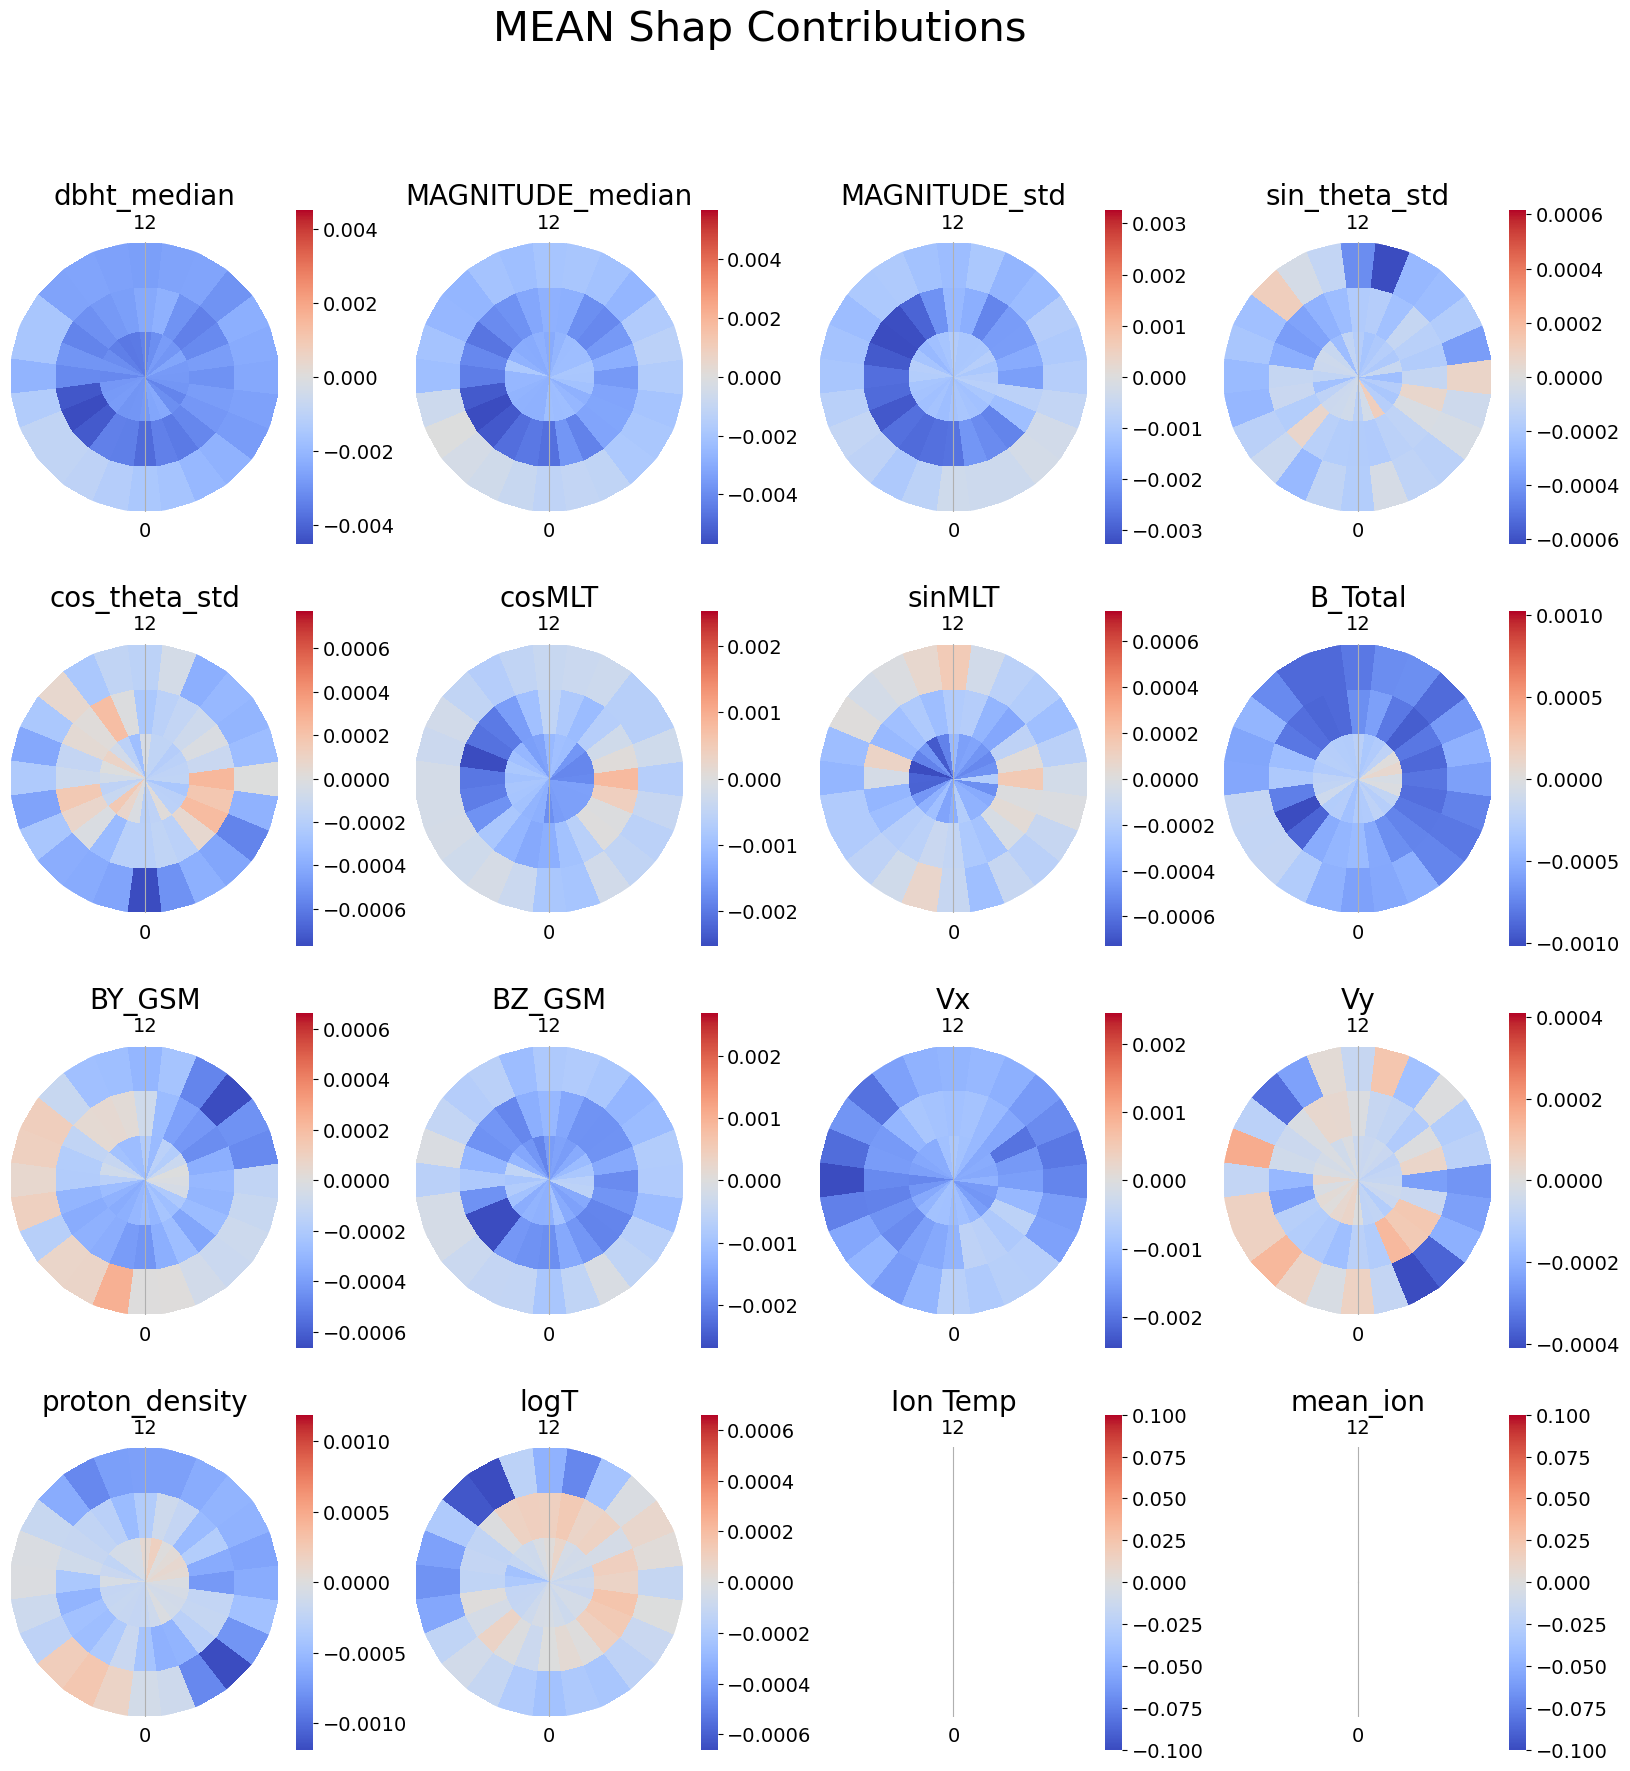

In [22]:
# plotting the results
stat = 'mean'

plotting_dict = {feat:pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']) for feat in feature_list}
plotting_dict['pixel_ion'] = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
plotting_dict['mean_ion'] = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
for key, value in plotting_dict.items():
	if key == 'pixel_ion' or key == 'mean_ion':
		for i, name in enumerate(names):
			for j in range(0, 24):
				value.loc[j, name] = pixel_dict[name][j][stat] if key == 'pixel_ion' else mean_dict[name][j][stat]
	else:
		for i, name in enumerate(names):
			for j in range(0, 24):
				value.loc[j, name] = shap_dict[key][name][j][stat]

# plotting_norm = mpl.colors.Normalize(vmin=00, vmax=1)
plotting_norm = None

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
# theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_ticks = np.linspace(0, 2*np.pi, 2, endpoint=False)
# theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']
theta_labels = ['0','12']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(4,4, figsize=(20,20), subplot_kw=dict(projection='polar'))
fig.suptitle(f'{stat.upper()} Shap Contributions', fontsize=30)

for i, (key,value) in enumerate(plotting_dict.items()):
	ax = axs[i//4, i%4]

	# Plotting the shap contributions on a polar plot
	ax.set_theta_zero_location('S')
	r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
	scale = max(value.max().max(), np.abs(value.min().min()))
	if stat != 'std':
		plotting_norm = mpl.colors.Normalize(vmin=-scale, vmax=scale)
		cmap='coolwarm'
	else:
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=scale)
		cmap='magma'
	cbar = fig.colorbar(ax.pcolormesh(th, r, value.astype(float), cmap=cmap, norm=plotting_norm), ax=ax)
	if key == 'pixel_ion':
		ax.set_title('Ion Temp')
	else:
		ax.set_title(key)
	ax.invert_yaxis()
	ax.set_xticks(theta_ticks)
	ax.set_xticklabels(theta_labels)
	ax.set_yticks([])

plt.savefig(f'plots/shap_polar_plot_{stat}.png')

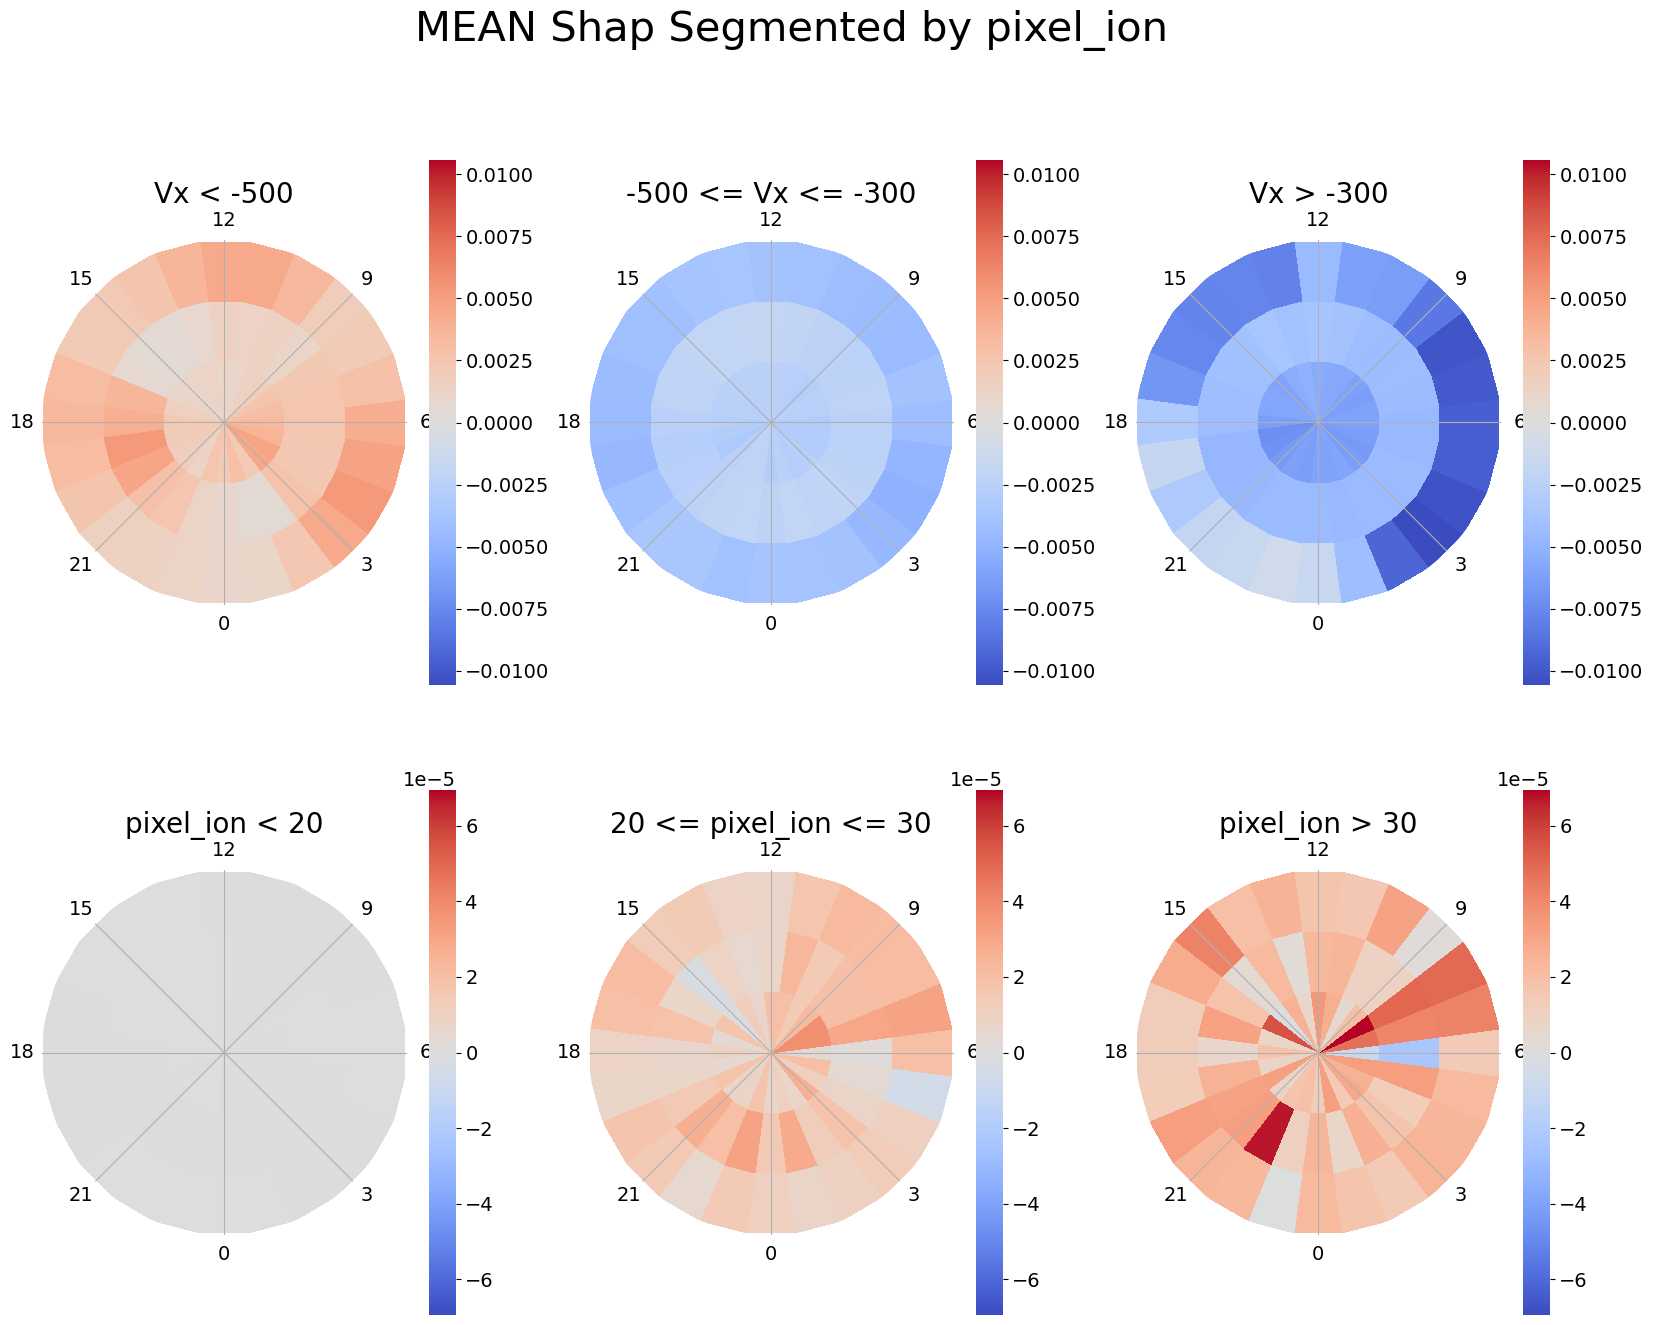

: 

In [199]:
lower_lat_bound = 55
upper_lat_bound = 65
sep_vars = ['Vx', 'pixel_ion']
sep_vars_bins = [-500, -300], [20,30]
stat = 'mean'

def get_sep_var_and_lat_bins(df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound):
	
	if sep_var_bins == None:
		sep_var_bins = [df[sep_var].quantile(0.25), df[sep_var].quantile(0.75)]

	if 'MLAT' not in df.columns:
		raise ValueError('MLAT column not found in the dataframe')
	if sep_var not in df.columns:
		raise ValueError(f'{sep_var} column not found in the dataframe')
	
	var_sep_low_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] > sep_var_bins[1])]
	var_sep_low_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]
	var_sep_low_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]


	final_dict = {'low_mlat_low_sep': var_sep_low_mlat_low, 'low_mlat_mid_sep': var_sep_mid_mlat_low, 'low_mlat_high_sep': var_sep_high_mlat_low,
				  'mid_mlat_low_sep': var_sep_low_mlat_mid, 'mid_mlat_mid_sep': var_sep_mid_mlat_mid, 'mid_mlat_high_sep': var_sep_high_mlat_mid,
				  'high_mlat_low_sep': var_sep_low_mlat_high, 'high_mlat_mid_sep': var_sep_mid_mlat_high, 'high_mlat_high_sep': var_sep_high_mlat_high}
	
	return final_dict


def calculating_individual_mlt_metrics(dict, stat='mean'):

	results_dict = {'low_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']), 
					'mid_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']), 
					'high_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])}

	lats = ['low', 'mid', 'high']
	var_seps = ['low', 'mid', 'high']

	# calculating the metrics for the low, mid and high latitudes
	for lat in lats:
		for sep in var_seps:
			for i in range(0, 24):
				temp_df = dict[f'{lat}_mlat_{sep}_sep'][dict[f'{lat}_mlat_{sep}_sep']['MLT'] == i]
				try:
					if stat == 'mean':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df['shap'].mean()
					elif stat == 'median':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df['shap'].median()
					elif stat == 'std':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df['shap'].std()

					else:
						raise ValueError(f'Stat: {stat} not recognized')

				except ValueError:
					print(f'No data found for {lat} lat and {sep} sep at {i} MLT')
					print(dict[f'{lat}_mlat_{sep}_sep'])
					results_dict[f'{sep}_sep_var_df'].loc[i,lat] = np.nan
					
			results_dict[f'{sep}_sep_var_df'] = results_dict[f'{sep}_sep_var_df'].astype(float)

	return results_dict

fig, axes = plt.subplots(2,3, figsize=(20, 15), subplot_kw=dict(projection='polar'))

for i, (sep_var, sep_var_bins) in enumerate(zip(sep_vars, sep_vars_bins)):

	if (sep_var == 'pixel_ion'):
		feature_df = pd.DataFrame({'shap':ion_temp_df['shap'], 
								sep_var:ion_temp_df['testing'],
							'MLAT':ion_temp_df['MLAT'],
							'MLT':ion_temp_df['MLT'],})
	elif (sep_var == 'mean_ion'):
		feature_df = pd.DataFrame({'shap':mean_ions_df['shap'], 
								sep_var:mean_ions_df['testing'],
							'MLAT':mean_ions_df['MLAT'],
							'MLT':mean_ions_df['MLT'],})
	else:
		feature_df = pd.DataFrame({'shap':mean_shap_df[sep_var], 
								sep_var:X_df[sep_var],
							'MLAT':mean_shap_df['MLAT'],
							'MLT':mean_shap_df['MLT'],})

	shap_contribution_dict = get_sep_var_and_lat_bins(feature_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)

	if sep_var_bins == None:
		sep_var_bins = ['25%', '75%']

	results = calculating_individual_mlt_metrics(shap_contribution_dict, stat=stat)

	# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
	rad = [0,1,2]
	theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
	theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

	# setting global plotting params
	mpl.rcParams['axes.linewidth'] = 0
	mpl.rcParams['font.size'] = 14
	mpl.rcParams['axes.titlesize'] = 20
	mpl.rcParams['axes.labelsize'] = 16
	mpl.rcParams['xtick.labelsize'] = 14


	# plotting the results segmented by parameter values
	plt.suptitle(f'{stat.upper()} Shap Segmented by {sep_var}', fontsize=30)
	scale = max([results['low_sep_var_df'].max().max(), np.abs(results['low_sep_var_df'].min().min()),
				results['mid_sep_var_df'].max().max(), np.abs(results['mid_sep_var_df'].min().min()),
				results['high_sep_var_df'].max().max(), np.abs(results['high_sep_var_df'].min().min())])

	for j, (key, value) in enumerate(results.items()):
		if j == 0:
			axes[i,j].set_title(f'{sep_var} < {sep_var_bins[0]}')
		elif j == 1:
			axes[i,j].set_title(f'{sep_var_bins[0]} <= {sep_var} <= {sep_var_bins[1]}')
		else:
			axes[i,j].set_title(f'{sep_var} > {sep_var_bins[1]}')
		if stat != 'std':
			plotting_norm = mpl.colors.Normalize(vmin=-scale, vmax=scale)
			cmap='coolwarm'
		else:
			plotting_norm = mpl.colors.Normalize(vmin=0, vmax=scale)
			cmap='magma'
		axes[i,j].set_theta_zero_location('S')
		r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
		cbar = fig.colorbar(axes[i,j].pcolormesh(th, r, value, cmap=cmap, norm=plotting_norm), ax=axes[i,j])
		
		axes[i,j].invert_yaxis()
		axes[i,j].set_xticks(theta_ticks)
		axes[i,j].set_xticklabels(theta_labels)
		axes[i,j].set_yticks([])
plt.savefig(f'plots/shap_polar_plot_{stat}_segmented_by_V.png')


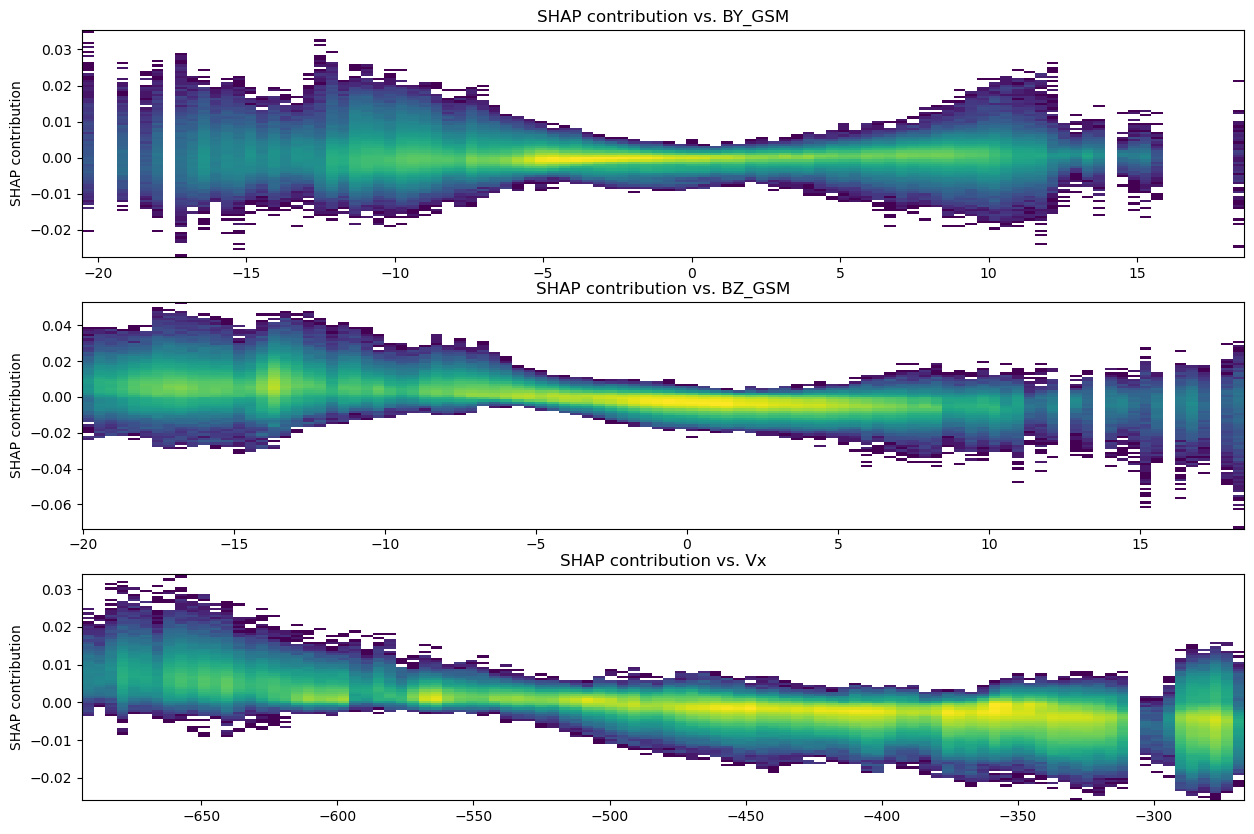

In [25]:
feature = ['BY_GSM', 'BZ_GSM', 'Vx']
# locating the colimn number of these features


fig, axes = plt.subplots(len(feature), 1, figsize=(15, 10))

for i, ax in enumerate(axes):
	ax.hist2d(X_df[feature[i]], mean_shap_df[feature[i]], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
	ax.set_title(f'SHAP contribution vs. {feature[i]}')
	ax.set_ylabel('SHAP contribution')
plt.savefig(f'plots/{feature[0]}_and_{feature[1]}')

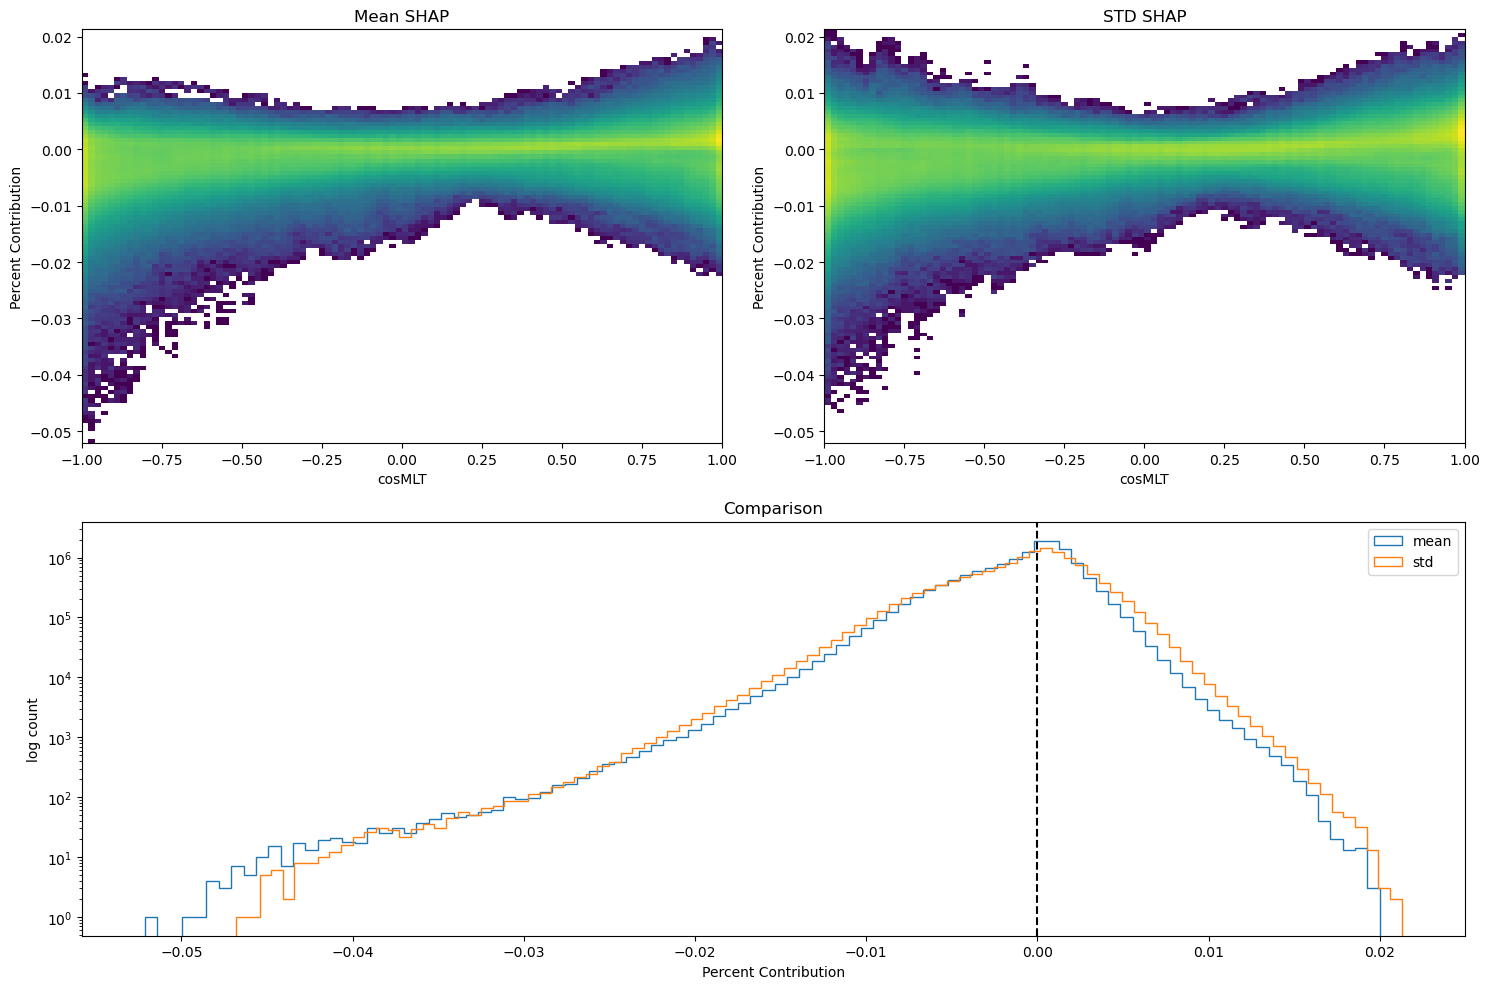

In [ ]:
feature = 'cosMLT'

vmin = np.min([np.min(swmag_std_shap_df[feature]), np.min(swmag_mean_shap_df[feature])])
vmax = np.max([np.max(swmag_std_shap_df[feature]),np.max(swmag_mean_shap_df[feature])])

fig, axes = plt.subplot_mosaic("AB;DD", figsize=(15,10))
axes['A'].hist2d(transformed_X_df[feature], swmag_mean_shap_df[feature], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
axes['B'].hist2d(transformed_X_df[feature], swmag_std_shap_df[feature], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
plt.title(f'{feature}')
axes['A'].set_ylabel('Percent Contribution')
axes['A'].set_xlabel(feature)
axes['A'].set_xlim(np.min(transformed_X_df[feature]), np.max(transformed_X_df[feature]))
axes['A'].set_ylim(vmin, vmax)
axes['A'].set_title('Mean SHAP')

axes['B'].set_xlim(np.min(transformed_X_df[feature]), np.max(transformed_X_df[feature]))
axes['B'].set_ylim(vmin, vmax)
axes['B'].set_xlabel(feature)
axes['B'].set_ylabel('Percent Contribution')
axes['B'].set_title('STD SHAP')

axes['D'].set_title('Comparison')
axes['D'].hist(swmag_mean_shap_df[feature], bins=100, log=True, histtype='step', label='mean')
axes['D'].hist(swmag_std_shap_df[feature], bins=100, log=True, histtype='step', label='std')
axes['D'].set_ylabel('log count')
axes['D'].set_xlabel('Percent Contribution')
axes['D'].axvline(0, linestyle='--', color='k')
axes['D'].legend()

plt.tight_layout()
plt.savefig(f'plots/{feature}_swmag_shap_value_distributions.png')

# getting area under the curve of the 1D histograms
from sklearn.metrics import auc
mean_hist, mean_bins = np.histogram(swmag_mean_shap_df[feature], bins=100)
std_hist, std_bins = np.histogram(swmag_std_shap_df[feature], bins=100)
mean_area = auc(mean_bins[:-1], mean_hist)
std_area = auc(std_bins[:-1], std_hist)


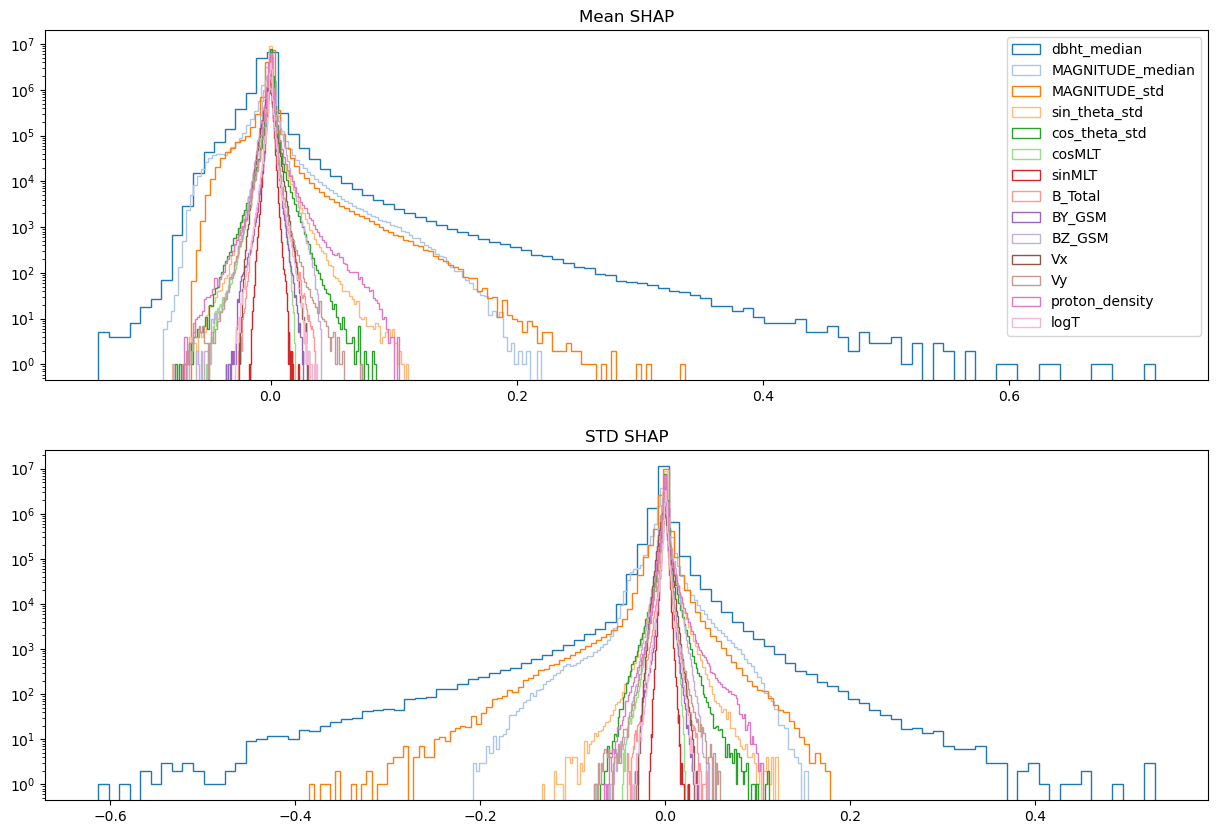

In [ ]:
colors = sns.color_palette('tab20')

fig, axes = plt.subplots(2,1, figsize=(15,10))

for i, col in enumerate(shap_values['features']):
	axes[0].hist(swmag_mean_shap_df[col], bins=100, log=True, histtype='step', label=col, color=colors[i])
	axes[1].hist(swmag_std_shap_df[col], bins=100, log=True, histtype='step', label=col, color=colors[i])

axes[0].set_title('Mean SHAP')
axes[1].set_title('STD SHAP')

axes[0].legend()
plt.show()

In [ ]:
# individual_cluster_to_examine = 'canadian_cluster'
mean_shap, std_shap, X, mu, sigma, error = [], [], [], [], [], []
dataframes_to_make = ['mean_shap_df', 'std_shap_df', 'transformed_X_df']
time_dict = {f'{feature}':{} for feature in shap_values['features']}

for feat in time_dict.keys():
	for df in dataframes_to_make:
		time_dict[feat][df] = pd.DataFrame()
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
		if f'{model_type}_shap' in region.keys():

			region[f'{model_type}_shap']['mean_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][0][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)
			region[f'{model_type}_shap']['std_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][1][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)

			for key in region[f'{model_type}_shap'].keys():
				if isinstance(region[f'{model_type}_shap'][key], torch.Tensor):
					region[f'{model_type}_shap'][key] = region[f'{model_type}_shap'][key].cpu().detach().numpy()

			try:
				region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap'].reshape(region[f'{model_type}_shap']['mean_shap'].shape[0], region[f'{model_type}_shap']['mean_shap'].shape[2], region[f'{model_type}_shap']['mean_shap'].shape[3])
				region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap'].reshape(region[f'{model_type}_shap']['std_shap'].shape[0], region[f'{model_type}_shap']['std_shap'].shape[2], region[f'{model_type}_shap']['std_shap'].shape[3])
				region[f'{model_type}_shap']['xtest'] = region[f'{model_type}_shap']['xtest'].reshape(region[f'{model_type}_shap']['xtest'].shape[0], region[f'{model_type}_shap']['xtest'].shape[2], region[f'{model_type}_shap']['xtest'].shape[3])

				mean_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['mean_shap']), axis=1),axis=1)
				region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap']/mean_added[:,None,None]

				std_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['std_shap']), axis=1),axis=1)
				region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap']/std_added[:,None,None]

			except:
				# print('We already did this, skipping....')
				pass

			region_scaler = scalers[reg][model_type]['swmag_scaler']


			for v, var in enumerate(time_dict.keys()):
				time_dict[var]['mean_shap_df'] = pd.concat([time_dict[var]['mean_shap_df'], pd.DataFrame(region[f'{model_type}_shap']['mean_shap'][:,:,v])], axis=0)
				time_dict[var]['std_shap_df'] = pd.concat([time_dict[var]['std_shap_df'], pd.DataFrame(region[f'{model_type}_shap']['std_shap'][:,:,v])], axis=0)
				time_dict[var]['transformed_X_df'] = pd.concat([time_dict[var]['transformed_X_df'], \
																pd.DataFrame(np.array([region_scaler.inverse_transform(region[f'{model_type}_shap']['xtest'][i,:,:]) \
																for i in range(region[f'{model_type}_shap']['xtest'].shape[0])])[:,:,v])], axis=0)

			# mu.append(np.concatenate(concatenated_mu, axis=0))
			# sigma.append(np.concatenate(concatenated_sigma, axis=0))
			# error.append(np.concatenate(concatenated_error, axis=0))

			mean_shap.append(np.concatenate(region[f'{model_type}_shap']['mean_shap'], axis=0))
			std_shap.append(np.concatenate(region[f'{model_type}_shap']['std_shap'], axis=0))
			X.append(region_scaler.inverse_transform(np.concatenate(region[f'{model_type}_shap']['xtest'], axis=0)))

time_columns = [f't-{30-i}' for i in range(0,30)]
for var in time_dict.keys():
	for df in time_dict[var]:
		print(f'Creating {var} {df} dataframe')
		print(time_dict[var][df].shape)
		time_dict[var][df].columns = time_columns

mean_shap = np.concatenate(mean_shap, axis=0)
std_shap = np.concatenate(std_shap, axis=0)
X = np.concatenate(X, axis=0)
# mu = np.concatenate(mu, axis=0)
# sigma = np.concatenate(sigma, axis=0)
# error = np.concatenate(error, axis=0)

mean_shap_df = pd.DataFrame(mean_shap, columns=shap_values['features'])
std_shap_df = pd.DataFrame(std_shap, columns=shap_values['features'])
transformed_X_df = pd.DataFrame(X, columns=shap_values['features'])
# mu_df = pd.DataFrame(mu, columns=shap_values['features'])
# sigma_df = pd.DataFrame(sigma, columns=shap_values['features'])
# error_df = pd.DataFrame(error, columns=shap_values['features'])



Creating dbht_median mean_shap_df dataframe
(461031, 30)
Creating dbht_median std_shap_df dataframe
(461031, 30)
Creating dbht_median transformed_X_df dataframe
(461031, 30)
Creating MAGNITUDE_median mean_shap_df dataframe
(461031, 30)
Creating MAGNITUDE_median std_shap_df dataframe
(461031, 30)
Creating MAGNITUDE_median transformed_X_df dataframe
(461031, 30)
Creating MAGNITUDE_std mean_shap_df dataframe
(461031, 30)
Creating MAGNITUDE_std std_shap_df dataframe
(461031, 30)
Creating MAGNITUDE_std transformed_X_df dataframe
(461031, 30)
Creating sin_theta_std mean_shap_df dataframe
(461031, 30)
Creating sin_theta_std std_shap_df dataframe
(461031, 30)
Creating sin_theta_std transformed_X_df dataframe
(461031, 30)
Creating cos_theta_std mean_shap_df dataframe
(461031, 30)
Creating cos_theta_std std_shap_df dataframe
(461031, 30)
Creating cos_theta_std transformed_X_df dataframe
(461031, 30)
Creating cosMLT mean_shap_df dataframe
(461031, 30)
Creating cosMLT std_shap_df dataframe
(461031

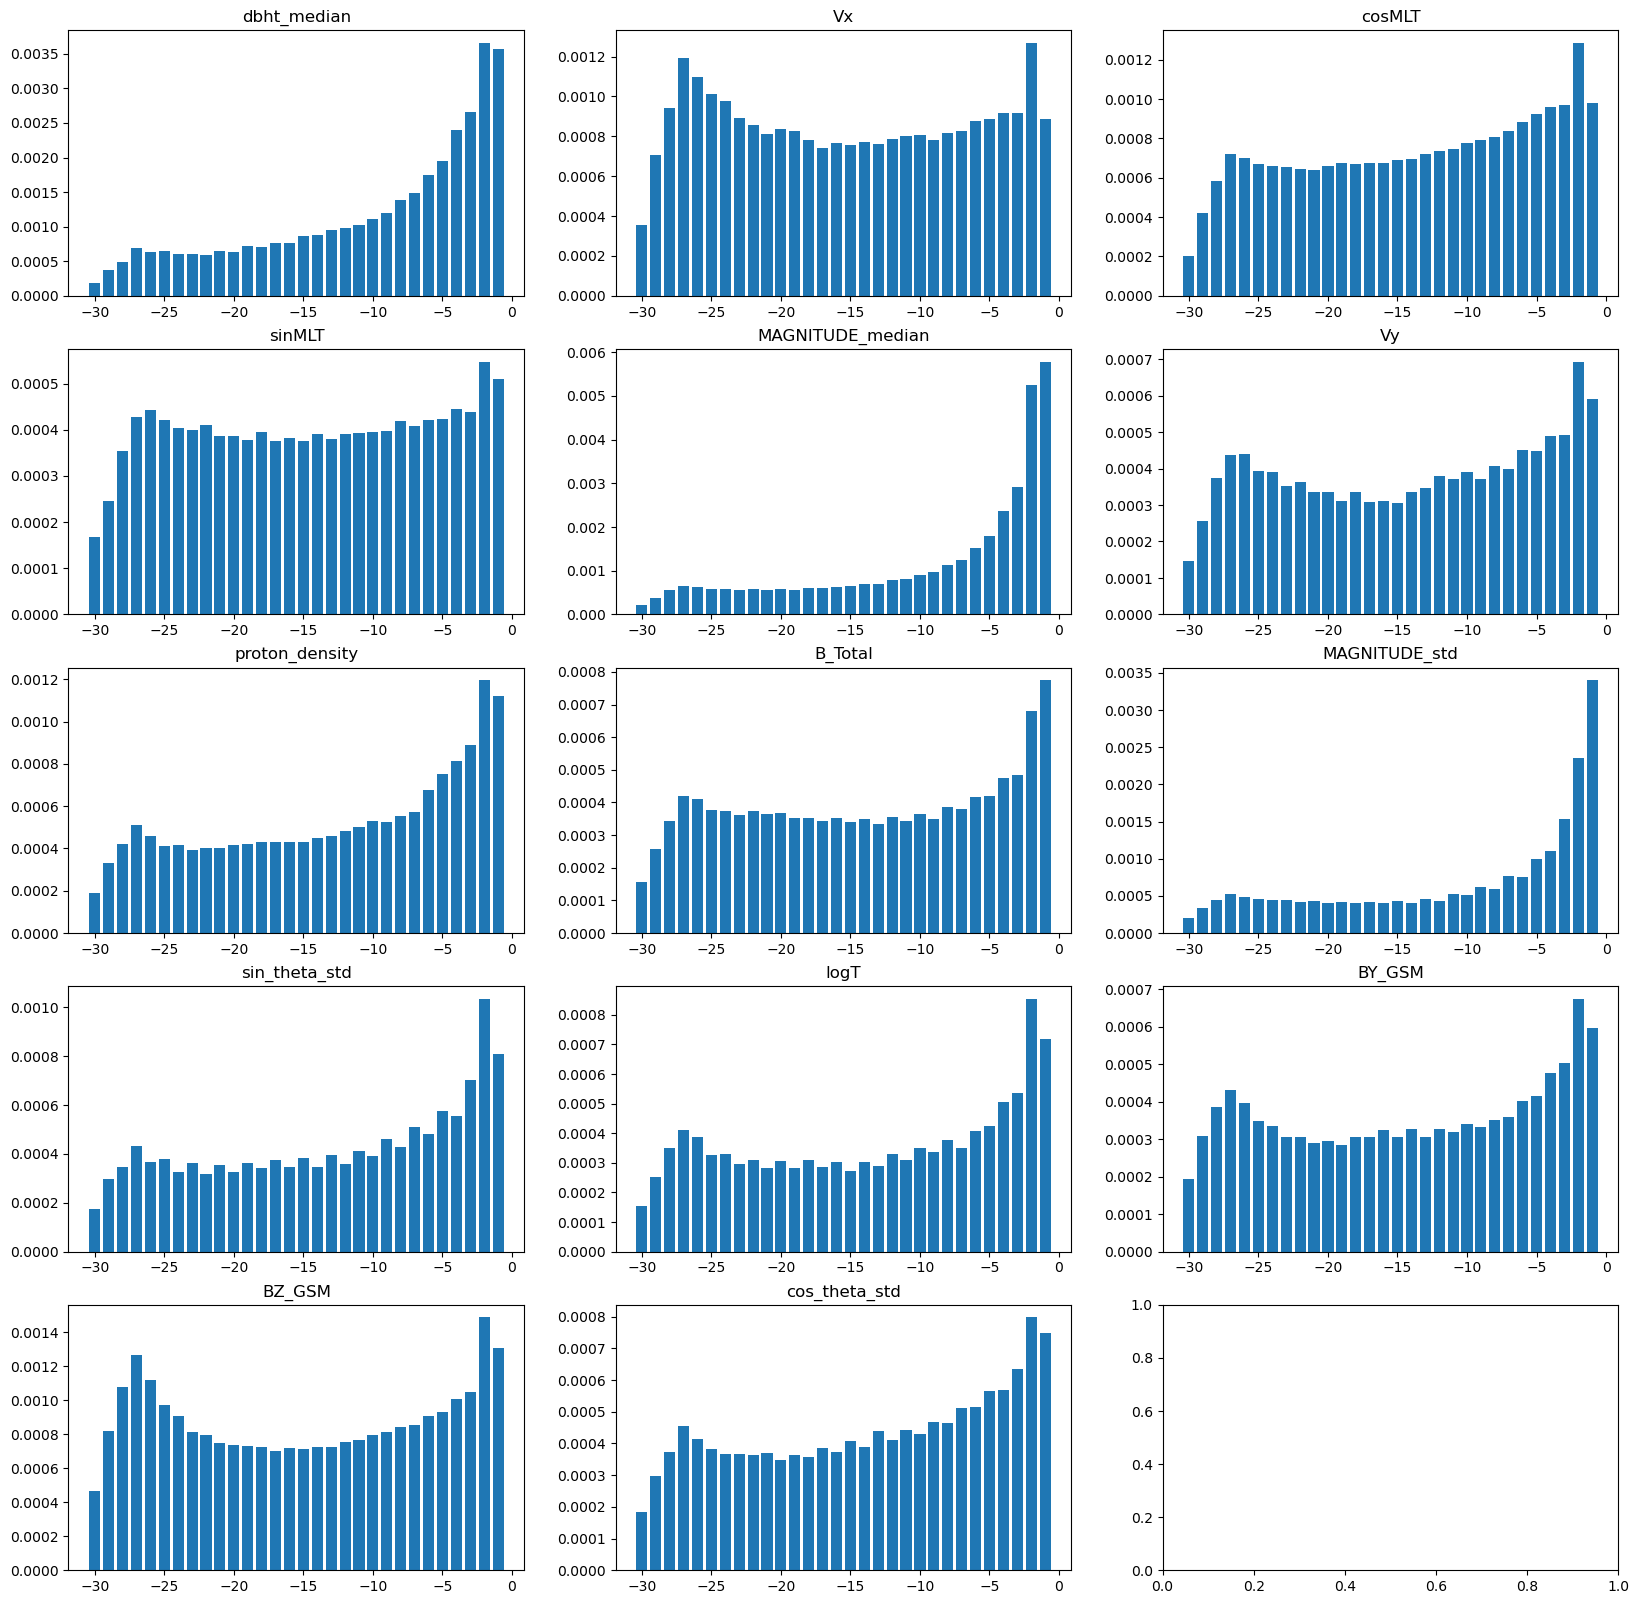

In [ ]:
# var = 'BY_GSM'
df = 'std_shap_df'

fig, axes = plt.subplots(5, 3, figsize=(20,20))
for i, var in enumerate(time_dict.keys()):
	k = i%3
	j = i%5
	axes[j,k].bar([i-30 for i in range(0,30)], time_dict[var][df].abs().mean(axis=0))
	axes[j,k].set_title(var)
plt.savefig(f'plots/time_history_{df}.png')

In [ ]:
results = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		results[key] = {}
		if key in list_of_oversampled_regions:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-oversampling.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling_oversampling.feather')
		else:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-1.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling.feather')
		results[key]['mean_lat'] = utils.getting_mean_lat(region['stations'])

for cluster in cluster_dict.values():
	for region in cluster['regions'].values():
		region['mean_lat'] = utils.getting_mean_lat(region['stations'])

Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [ ]:
plotting_df = pd.DataFrame()
mlt_arr, actual_arr, mlat_arr = [], [], []
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():

		df = utils.loading_supermag(region['mlt_station'])
		dates = region['swmag_shap']['Date_UTC']

		cluster_dict[cluster]['regions'][reg]['test_mlt'] = df[df.index.isin(dates['Date_UTC'])]['MLT']
		if 'dates' in results[reg]['swmag_results'].keys():
			results[reg]['swmag_results'].set_index('dates', inplace=True)
		results[reg]['swmag_results']['MLT'] = cluster_dict[cluster]['regions'][reg]['test_mlt']
		results[reg]['swmag_results']['error'] = np.abs(results[reg]['swmag_results']['predicted_mean'] - results[reg]['swmag_results']['actual'])
		results[reg]['swmag_results']['mlat'] = cluster_dict[cluster]['regions'][reg]['mean_lat']
		plotting_df = pd.concat([plotting_df, results[reg]['swmag_results']], axis=0)

		unbroadcasted_mlt = results[reg]['swmag_results']['MLT'].to_numpy()
		unbroadcasted_actual = results[reg]['swmag_results']['actual'].to_numpy()
		unbroadcasted_mlat = results[reg]['swmag_results']['mlat'].to_numpy()

		concatenated_mlt = np.concatenate([np.concatenate([unbroadcasted_mlt[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
		concatenated_actual = np.concatenate([np.concatenate([unbroadcasted_actual[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)

		# mlt_arr.append(np.concatenate(concatenated_mlt, axis=0))
		# actual_arr.append(np.concatenate(concatenated_actual, axis=0))

		mlt_arr.append(np.repeat(results[reg]['swmag_results']['MLT'].to_numpy(), 30))
		actual_arr.append(np.repeat(results[reg]['swmag_results']['actual'].to_numpy(), 30))
		mlat_arr.append(np.repeat(results[reg]['swmag_results']['mlat'].to_numpy(), 30))

mlt_arr = np.concatenate(mlt_arr, axis=0)
actual_arr = np.concatenate(actual_arr, axis=0)
mlat_arr = np.concatenate(mlat_arr, axis=0)
time_history = np.concatenate((np.array([30-i for i in range(0,30)]),)*(len(mlt_arr)//30), axis=0)

# mlt_df = pd.DataFrame(mlt_arr, columns=shap_values['features'])
# actual_df = pd.DataFrame(actual_arr, columns=shap_values['features'])

plotting_mlt_mlat_shap_mean = mean_shap_df.copy()
plotting_mlt_mlat_shap_mean['MLT'] = mlt_arr
plotting_mlt_mlat_shap_mean['mlat'] = mlat_arr
plotting_mlt_mlat_shap_mean['actual'] = actual_arr
plotting_mlt_mlat_shap_mean['time_history'] = time_history


Loading station NEW....
Loading station LET....
Loading station MEA....
Loading station STF....
Loading station GDH....
Loading station GDH....
Loading station NAQ....
Loading station LYC....
Loading station NUR....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station BEL....
Loading station BEL....
Loading station HRB....
Loading station WNG....
Loading station HRN....
Loading station KNY....
Loading station MMB....
Loading station CMO....
Loading station PIN....
Loading station BLC....


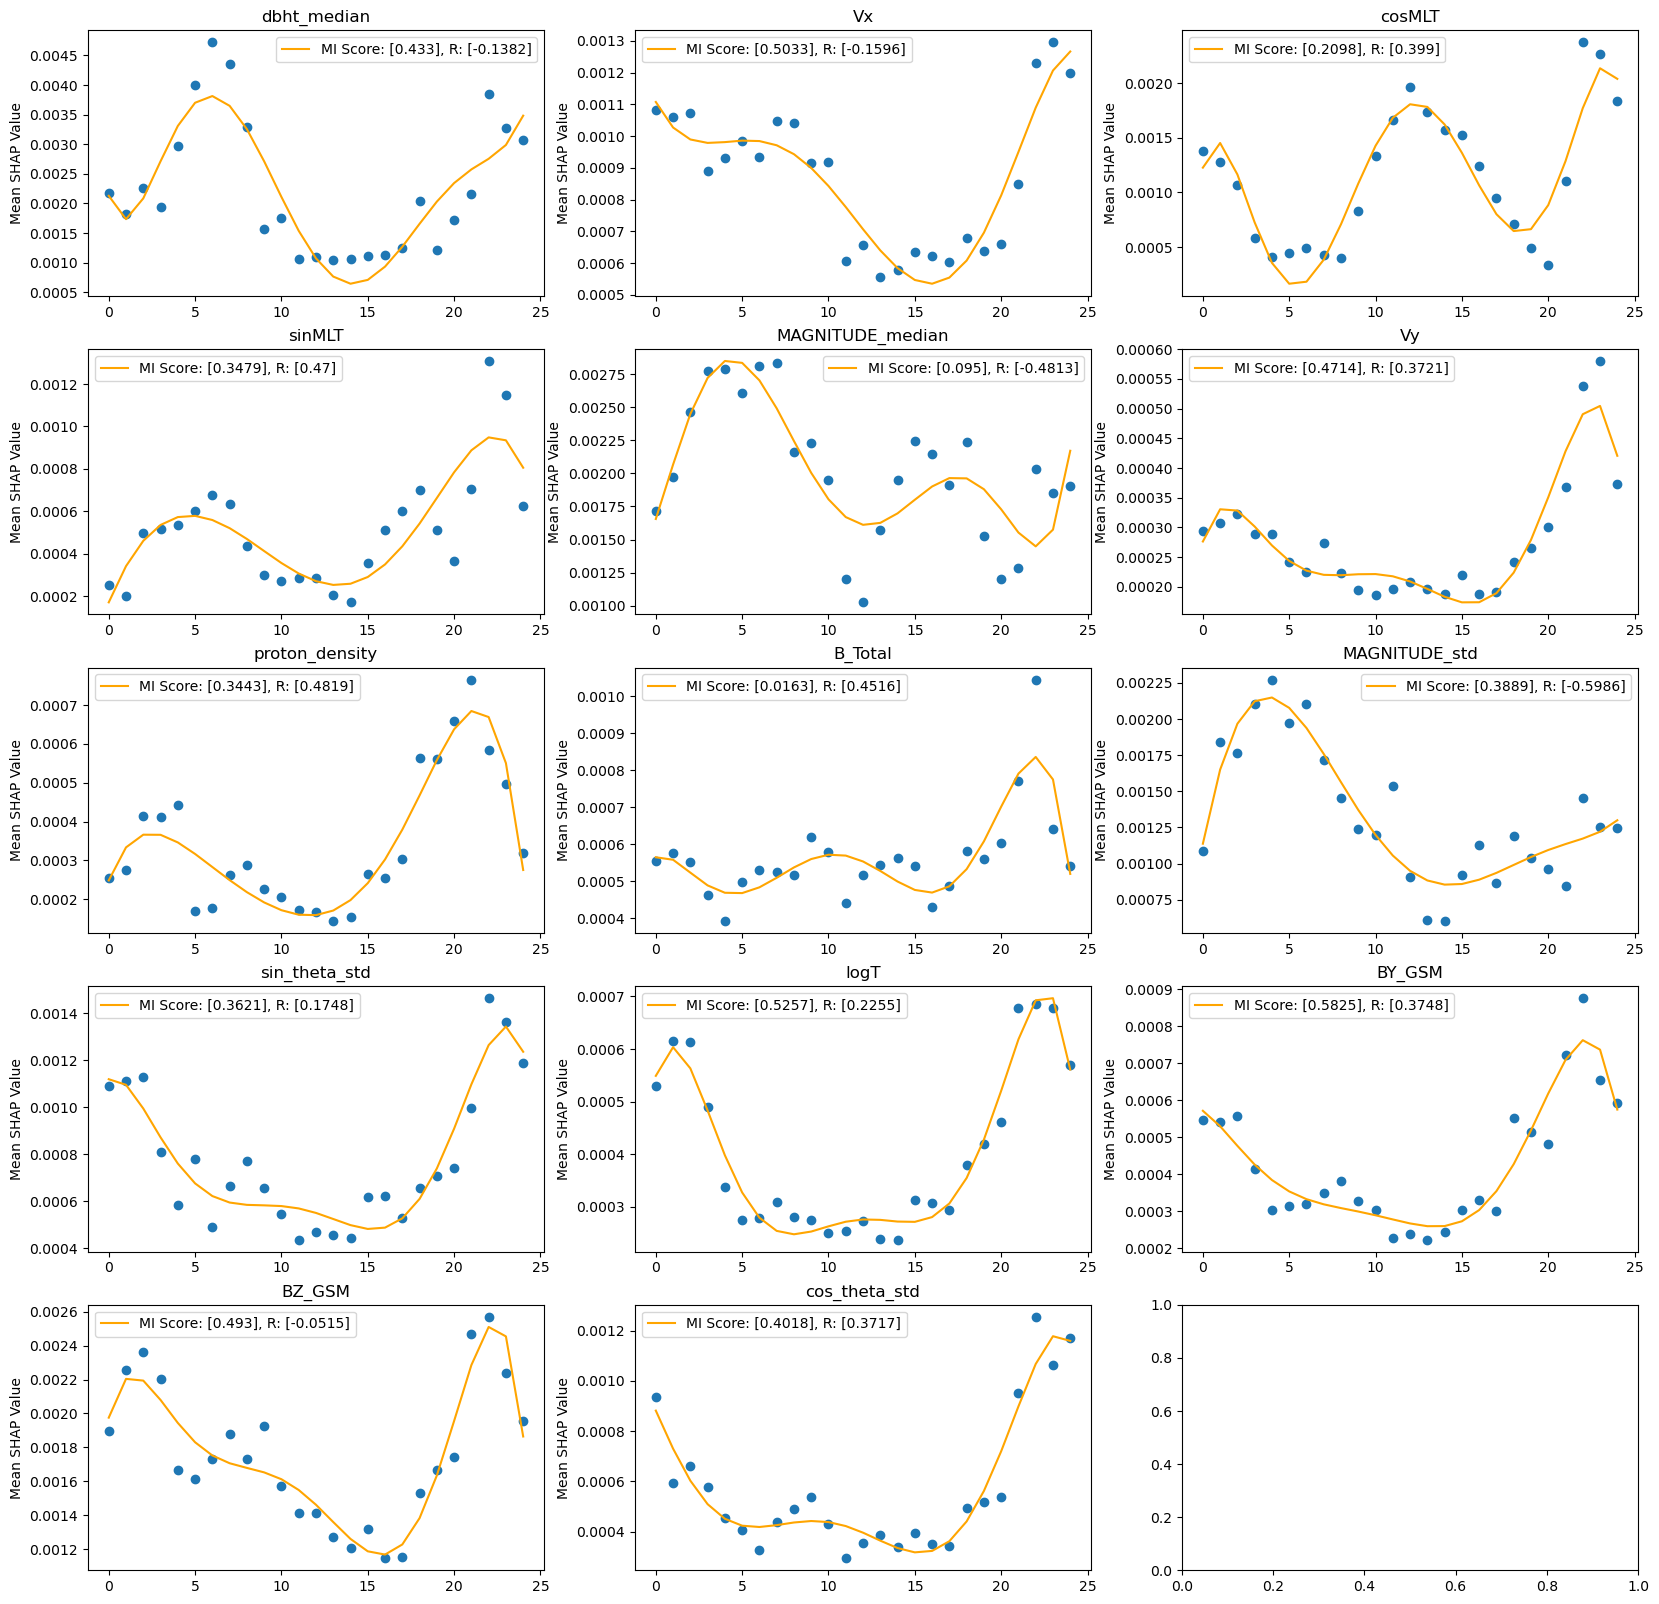

: 

In [ ]:
specific_mlat = 67
specific_mlt = None
absolute = True
aggregation_method = 'mean'
time_history = False
cut_mlt = False
if not cut_mlt:
	round_mlt = True
else:
	round_mlt = False
mlt_cuts = 1000
mlt_bins = np.linspace(0,24,mlt_cuts+1).tolist()
specific_plotting_df = plotting_mlt_mlat_shap_mean.copy()
specific_plotting_df['mlat'] = specific_plotting_df['mlat'].astype(int)

title = f'{aggregation_method}_shap_'

if round_mlt:
	specific_plotting_df['MLT'] = specific_plotting_df['MLT'].round(0)
elif cut_mlt:
	specific_plotting_df['MLT_bins'] = pd.cut(specific_plotting_df['MLT'], mlt_bins, labels=mlt_bins[:-1], include_lowest=True)
	# specific_plotting_df = specific_plotting_df.groupby('MLT_bins').agg(aggregation_method)
else:
	raise ValueError('Must specify either round_mlt or cut_mlt')

if specific_mlat is not None:
	specific_plotting_df = specific_plotting_df[specific_plotting_df['mlat']==specific_mlat]
	title += f'{specific_mlat}_'

if specific_mlt is not None:
	specific_plotting_df = specific_plotting_df[specific_plotting_df['MLT']==specific_mlt]
	title += f'{specific_mlt}_'

if time_history:
	if specific_mlat is None and specific_mlt is None:
		raise ValueError('Cannot plot time history without specifying MLAT or MLT')
	if 'MLT_bins' in specific_plotting_df.columns:
		raise ValueError('Cannot plot time history with MLT bins. Change to int rounded MLT')
	specific_plotting_df = specific_plotting_df.groupby('time_history').agg(aggregation_method)
	title += 'time_history_'

if not time_history:
	if (specific_mlat is not None and specific_mlt is not None):
		raise ValueError('Cannot plot with specifying both MLAT and MLT')

	if absolute:
		specific_plotting_df = specific_plotting_df.apply(lambda x: x.abs() if (x.dtype=='float') or (x.dtype=='int') else x)
		if 'MLT_bins' in specific_plotting_df.columns:
			specific_plotting_df = specific_plotting_df.groupby('MLT_bins').agg(aggregation_method)
		else:
			specific_plotting_df = specific_plotting_df.groupby('MLT').agg(aggregation_method)
	else:
		if 'MLT_bins' in specific_plotting_df.columns:
			specific_plotting_df = specific_plotting_df.groupby('MLT_bins').agg(aggregation_method)
		else:
			specific_plotting_df = specific_plotting_df.groupby('MLT').agg(aggregation_method)
	title += 'absolute_shap' if absolute else 'relative_shap'

fig, axes = plt.subplots(5,3,figsize=(20,20))
for i, var in enumerate(specific_plotting_df.columns):
	if var == 'actual' or var == 'MLT' or var == 'mlat' or var == 'error' or var == 'time_history':
		continue
	j = i % 5
	k = i % 3
	mlt = np.array(specific_plotting_df.index)
	shap = specific_plotting_df[var].to_numpy()
	z = np.polyfit(mlt, shap, 6)
	p = np.poly1d(z)
	MI_x = mlt.reshape(-1,1)
	MI_y = shap
	axes[j,k].plot(mlt, p(mlt), color='orange', label=f'MI Score: {mutual_info_regression(MI_x, MI_y).round(4)}, R: {r_regression(MI_x, MI_y).round(4)}')
	axes[j,k].scatter(mlt, shap)
	axes[j,k].set_ylabel('Mean SHAP Value')
	axes[j,k].set_title(f'{var}')
	axes[j,k].legend()
plt.savefig(f'plots/mean_{title}.png')